In [1]:
import fmpsdk
import pandas as pd
import numpy as np
apikey = 'eb96eccac2f06f6735f3b5597486f833'
from datetime import datetime, timedelta
import plotly.graph_objects as go
import plotly.express as px
import urllib.request
import dash_bootstrap_components as dbc
import matplotlib.pyplot as plt
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from pandas.plotting import lag_plot
from sklearn.model_selection import train_test_split, GridSearchCV
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor
from keras.metrics import mean_absolute_error
from nltk.sentiment.vader import SentimentIntensityAnalyzer

import warnings
warnings.filterwarnings('ignore')

## Business Problem: Stock prices are a a very important metric because they represent the value of publicly traded companies in  the eyes of society. There is also a strong financial incentive to have a higher stock value for current shareholders because stocks can be liquidated into currency. Stock prices fluctuate based on the supply and demand of stocks associated with a particular company. If stock price can be predicted it could bring these business values:
#### - Increased confidence of return when investing in a company's stock
#### - Increase the confidence of current shareholders regarding stock's direction which can influence their decision to buy/sell your stock
#### - Determine key metrics that drive a stock price up or down
#### - Forecasting stock crashes will lead to the minimization of capital loss
 

## Business Understanding: Predicting stock prices is not an easy task especially regarding the number of variables that go into it. Knowing that a stock price fluctuates based on supply and demand tells me how I will move forward. If I can collect general public sentiment towards a stock, current market trends, and the stock's recent direction, then I am confident that I can predict a stock's price. I will make two types of models for individual stocks, one that predicts the end of day price and one that predicts the price in 4 hours.

# Functions

In [2]:
def build_time_series_df(stock):
    """
    IN: stock : Stock symbol that will be used to build the time series data
    
    OUT: day_df : Dataframe that returns with columns date, close, high,
    change_over_time, volume, and date
    
    """
    #Determine date range, will start with 200 days in the past
    today = datetime.now()
    end_date = today - timedelta(days=200)
    day_stock = fmpsdk.historical_price_full(apikey, stock, from_date = end_date,
                                            to_date = today)
    
    #Construct Dataframe
    day_df = pd.DataFrame(columns = ['Date', 'Close', 'High', 'Change Over Time',
                                    'Volume'])
    dates = []
    closes = []
    highs = []
    change_over_time = []
    changes = []
    volumes = []
    

    #Fill Dataframe
    for day in day_stock['historical']:
        dates.append(day['date'])
        closes.append(day['close'])
        highs.append(day['high'])
        change_over_time.append(day['changeOverTime'])
        volumes.append(day['volume'])
        

    day_df.Date = dates
    day_df.Close = closes
    day_df.High = highs
    day_df['Change Over Time'] = change_over_time
    day_df.Volume = volumes

    day_df.Date = day_df.Date.apply(lambda dat: pd.to_datetime(dat))
    
 
    return day_df


In [3]:
def make_next_hour_pred(stock, series, model):
    cols = ['close_1day', 'close_2day','close_3day', 'high_1day',
              'high_2day', 'high_3day', 'low_1day', 'low_2day',
              'low_3day', 'vol_1day', 'vol_2day', 'vol_3day']
    X = pd.DataFrame(columns = cols)

    last_hour_data = fmpsdk.historical_chart(apikey, 'AAPL', "1hour")[0]

    X.close_1day = pd.Series(last_hour_data['close'])
    X.close_2day = pd.Series(series.Close_1hour[0])
    X.close_3day = pd.Series(series.Close_2hour[0])

    X.high_1day = pd.Series(last_hour_data['high'])
    X.high_2day = pd.Series(series.High_1hour[0])
    X.high_3day = pd.Series(series.High_2hour[0])

    X.low_1day = pd.Series(last_hour_data['low'])
    X.low_2day = pd.Series(series.Low_1hour[0])
    X.low_3day = pd.Series(series.Low_2hour[0])

    X.vol_1day = pd.Series(last_hour_data['volume'])
    X.vol_2day = pd.Series(series.Vol_1hour[0])
    X.vol_3day = pd.Series(series.Vol_2hour[0])

    pred = model.predict(X)
    
    return pred

In [4]:
def make_tomorrow_pred(stock, series, model):
    """
    IN: 
        stock: Stock symbol
        series : Dataframe prediction_df returned from build_general_model_daily_prediction_df
        model: Model retured From build_general_model_daily_prediction_df
    OUT:
        pred : Prediction for next stock day
    
    """
    cols = ['close_1day', 'close_2day','close_3day', 'high_1day',
              'high_2day', 'high_3day', 'cot_1day', 'cot_2day',
              'cot_3day', 'vol_1day', 'vol_2day', 'vol_3day', 'news_sent1day']
    X = pd.DataFrame(columns = cols)
    yesterday_data = fmpsdk.historical_price_full(apikey, stock)['historical'][0]
    
    a = vader_sentiment_analysis(apikey, stock, 20)
    
    X.news_sent1day = pd.Series(np.mean(trim_news_dates(datetime.today().strftime('%Y-%m-%d'), a).CompoundAvg))
    X.news_sent1day.fillna(0, inplace=True)

    X.close_1day = pd.Series(yesterday_data['close'])
    X.close_2day = pd.Series(series.Close_1day[0])
    X.close_3day = pd.Series(series.Close_2day[0])

    X.high_1day = pd.Series(yesterday_data['high'])
    X.high_2day = pd.Series(series.High_1day[0])
    X.high_3day = pd.Series(series.High_2day[0])

    X.cot_1day = pd.Series(yesterday_data['changeOverTime'])
    X.cot_2day = pd.Series(series.Cot_1day[0])
    X.cot_3day = pd.Series(series.Cot_2day[0])

    X.vol_1day = pd.Series(yesterday_data['volume'])
    X.vol_2day = pd.Series(series.Vol_1day[0])
    X.vol_3day = pd.Series(series.Vol_2day[0])

    pred = model.predict(X)
    
    return pred

In [5]:
def plot_history(history, style=['ggplot', 'seaborn-talk']):
    """
    SOURCE: Claude Fried (https://www.linkedin.com/in/claude-fried/)
    Plot history from History object (or history dict) 
    once Tensorflow model is trained.
    
    Parameters:
    -----------
    history:
        History object returned from a model.fit()
    style: string or list of strings (default: ['ggplot', 'seaborn-talk'])
        Style from matplotlib.
    """
    
    # We can pass in a model history object or a dictionary.
    if not isinstance(history, dict): # We prefer this type of check over `if type() == ...`
        history = history.history

    metrics_lst = [m for m in history.keys() if not m.startswith('val')]
    N = len(metrics_lst)
    with plt.style.context(style):
        fig, ax_lst = plt.subplots(nrows=N, figsize=(8, 4*(N)))
        ax_lst = [ax_lst] if N == 1 else ax_lst.flatten() # Flatten ax_lst.
        for metric, ax in zip(metrics_lst, ax_lst):
            val_m = f'val_{metric}'
            ax.plot(history[metric], label=metric)
            ax.plot(history[val_m], label=val_m)
            ax.set(title=metric.title(), xlabel='Epoch', ylabel=metric.title())
            ax.legend()
        fig.tight_layout()
        plt.show()

In [6]:
def vader_sentiment_analysis(apikey, ticker, limit=5000):
    """
    IN: 
    apikey: This should be your personalized api key. You can get one here 
    (https://fmpcloud.io/)

    ticker: This is the stock symbol as or trade name. e.g. TSLA, AAPL, GOOG

    limit: This number references how far back in date you want to go. If you
    want to find the date range please use get_timeframe() on this method's returned df.
    
    OUT: Pandas Dataframe
    """
    #Initialize the sentiment analyzer
    sid = SentimentIntensityAnalyzer()
    #Collect the data from the fmpsdk api
    news = fmpsdk.stock_news(apikey=apikey, tickers=ticker, limit=limit)
    #Construct the dataframe with predtermined columns
    df = pd.DataFrame(columns=['Date', 'Title', 'Text', 'CompoundScoreTitle',
                          'PositiveScoreTitle', 'NegativeScoreTitle', 
                          'CompoundScoreText', 'NeutralScoreTitle',
                           'NeutralScoreText', 'textLeans', 'titleLeans',
                          'PositiveScoreText', 'NegativeScoreText',
                          'CompoundAvg', 'Symbol'])
    
    dates = []
    titles = []
    text_ = []
    symbols = []


    #Loops through the news variable which contains the data from the api. For 
    #loop the lists dates, titles, & text_ get appended so that the df above can
    #then have three columns with data
    for article in news:
        dates.append(article['publishedDate'])
        titles.append(article['title'])
        text_.append(article['text']) 
        symbols.append(article['symbol'])
    df.Date = pd.to_datetime(dates)
    df.Title = titles
    df.Text = text_
    df.Symbol = symbols
    
    #Removes None values from text that can appear
    df.Text = df.Text.apply(lambda txt: txt if txt != None else('Blank'))
    #Scores the title of the articles using compound score
    df.CompoundScoreTitle = df.Title.apply(lambda title:
    sid.polarity_scores(title)['compound'])
    #Scores the title of the articles using positive score
    df.PositiveScoreTitle = df.Title.apply(lambda title:
        sid.polarity_scores(title)['pos'])
    #Scores the title of the articles using negative score
    df.NegativeScoreTitle = df.Title.apply(lambda title:
        sid.polarity_scores(title)['neg'])
    #Scores the title of the articles using neutral score
    df.NeutralScoreTitle = df.Title.apply(lambda title:
        sid.polarity_scores(title)['neu'])
    #Scores the text of the articles using compound score
    df.CompoundScoreText = df.Text.apply(lambda text:
        sid.polarity_scores(text)['compound'])
    #Scores the text of the articles using positive score
    df.PositiveScoreText = df.Text.apply(lambda text:
        sid.polarity_scores(text)['pos'])
    #Scores the text of the articles using negative score
    df.NegativeScoreText = df.Text.apply(lambda text:
        sid.polarity_scores(text)['neg'])
    #Scores the text of the articles using neutral score
    df.NeutralScoreText = df.Text.apply(lambda text:
        sid.polarity_scores(text)['neu'])
    
    #I will now add two columns to the dataframe that will tell me which way the
    #sentiment analyzer is leaning in regards to tile and text. I will be using
    #the comound score here because it is the best representation of positve/neutral
    #& negative scores.

    #If the title comound score is less than 0 I determine that the title leans negative
    #if the comound score is greater than 0 I dettermine that the title leans
    #positive. Otherwise neutral.
    df.titleLeans = df.CompoundScoreTitle.apply(lambda score:
                    'Negative' if score < 0 
                     else('Positive' if score > 0
                          else('Neutral')))
                        
    df.textLeans = df.CompoundScoreText.apply(lambda score:
                        'Negative' if score < 0 
                         else('Positive' if score > 0
                              else('Neutral')))
    #Now I will add the day of the week
    #Days of the week are numberd 0-6 where 0 is Monday
    df['weekday'] = df.Date.apply(lambda date:
                                  date.weekday())
    #The time corresponding with the date will also need to in it's own column
    #for later processing
    df['time'] = df.Date.apply(lambda date:
                               date.time())
    #Finally I add the average of the comound scores for the title and text of a 
    #given article
    df.CompoundAvg = (df.CompoundScoreTitle + df.CompoundScoreText)/2
    
    return df

In [7]:
def trim_news_dates(stock_prediction_day, df):
  """
  This function will trim a provided dataframe to only contain dates relevant to
  the stock_prediction_day.

  IN: 
   - stock_prediction_day: This is the date that one would like to predict a 
   stocks gain/loss should be a string in the form 'YYYY-MM-DD'
   - df: This is the data frame that will be trimmed and returned only contaning
   dates relavant to the prediction
  """

  #Set start_cutoff to one day before stock_prediction_day at 4:00 PM as
  #a pandas datetime object
  end_cutoff = pd.to_datetime(stock_prediction_day + ' 16:00:00')
  start_cutoff = end_cutoff - timedelta(days=1)
  
  return df.loc[(df.Date >= start_cutoff) &
       (df.Date <= end_cutoff)]

def determine_date_range(df):
  """
  IN: pandas data frame that you would like to know the date range of
  OUT: Date range in pandas.datetime format
  """
  end_date = df.Date[0]
  start_date = df.Date[df.shape[0]-1]
  return (start_date, end_date)

In [8]:
def build_xgboost_hourly_df(symbol):
    
    prediction_df = pd.DataFrame(columns = ['Close_1hour',
                                            'Close_2hour',
                                            'Close_3hour',
                                            #'Close_4day',
                                            #'Close_5day',
                                            'High_1hour',
                                            'High_2hour',
                                            'High_3hour',
                                            #'High_4day',
                                           #'High_5day',
                                            'Low_1hour',
                                            'Low_2hour',
                                           'Low_3hour',
                                           # 'Cot_4day',
                                            #'Cot_5day',
                                           'Vol_1hour',
                                            'Vol_2hour',
                                            'Vol_3hour',
                                            #'Vol_4day',
                                            #'Vol_5day',
                                            'value',
                                            'Time'
                                       ])
    stock_df = build_time_series_hourly_df(symbol)
    prediction_df.value = stock_df.Close[0:(stock_df.shape[0])-5]
    prediction_df.Time = stock_df.Time
    day_1_close = []
    day_2_close = []
    day_3_close = []
    day_4_close = []
    day_5_close = []

    High_1day = []
    High_2day = []
    High_3day = []
    High_4day = []
    High_5day = []

    Low_1day = []
    Low_2day = []
    Low_3day = []
    Low_4day= []
    Low_5day= []

    Vol_1day = []
    Vol_2day = []
    Vol_3day = []
    Vol_4day = []
    Vol_5day = []
    for i in range(len(prediction_df.value)):

        day_1_close.append(stock_df.Close[i+1])
        day_2_close.append(stock_df.Close[i+2])
        day_3_close.append(stock_df.Close[i+3])
#         day_4_close.append(stock_df.Close[i+4])
#         day_5_close.append(stock_df.Close[i+5])

        High_1day.append(stock_df.High[i+1])
        High_2day.append(stock_df.High[i+2])
        High_3day.append(stock_df.High[i+3])
#         High_4day.append(stock_df.High[i+4])
#         High_5day.append(stock_df.High[i+5])

        Low_1day.append(stock_df['Low'][i+1])
        Low_2day.append(stock_df['Low'][i+2])
        Low_3day.append(stock_df['Low'][i+3])
#         Cot_4day.append(stock_df['Change Over Time'][i+4])
#         Cot_5day.append(stock_df['Change Over Time'][i+5])

        Vol_1day.append(stock_df.Volume[i+1])
        Vol_2day.append(stock_df.Volume[i+2])
        Vol_3day.append(stock_df.Volume[i+3])
#         Vol_4day.append(stock_df.Volume[i+4])
#         Vol_5day.append(stock_df.Volume[i+5])

    prediction_df.Close_1hour = day_1_close
    prediction_df.Close_2hour = day_2_close
    prediction_df.Close_3hour = day_3_close
#     prediction_df.Close_4day = day_4_close
#     prediction_df.Close_5day = day_5_close

    prediction_df.High_1hour = High_1day
    prediction_df.High_2hour = High_2day
    prediction_df.High_3hour = High_3day
#     prediction_df.High_4day= High_4day
#     prediction_df.High_5day= High_5day

    prediction_df.Low_1hour = Low_1day
    prediction_df.Low_2hour = Low_2day
    prediction_df.Low_3hour = Low_3day
#     prediction_df.Cot_4day = Cot_4day
#     prediction_df.Cot_5day = Cot_5day

    prediction_df.Vol_1hour = Vol_1day
    prediction_df.Vol_2hour = Vol_2day
    prediction_df.Vol_3hour = Vol_3day
#     prediction_df.Vol_4day = Vol_4day
#     prediction_df.Vol_5day = Vol_5day

        
    return prediction_df

In [9]:
def build_time_series_hourly_df(symbol):

    hourly_stock = fmpsdk.historical_chart(apikey, symbol, "1hour")
    
    hourly_df = pd.DataFrame(columns = ['Time', 'Close', 'High', 'Volume', 'Low'])
    opens = []
    times = []
    closes = []
    highs = []
    volumes = []
    lows = []
    for hour in hourly_stock:
        times.append(hour['date'])
        opens.append(hour['open'])
        closes.append(hour['close'])
        highs.append(hour['high'])
        volumes.append(hour['volume'])
        lows.append(hour['low'])

    hourly_df.Time = times
    hourly_df.Close = closes
    hourly_df.High = highs
    hourly_df.Volume = volumes
    hourly_df.Low = lows

 
    return hourly_df


In [10]:
def build_general_model_daily_prediction_df(stock):
    """
    IN: stock : Stock Symbol
    
    OUT: 
        xgboost_prediction_df: Dataframe containing train, test, and prediction 
    results
        xg: Model used for prediction
        prediction_df : Dataframe used to train and test model
        mae : Mean Absolue Error of model from test results
          
    """
    prediction_df = build_xgboost_df(stock)

    test_data, train_data = prediction_df[0:int(len(prediction_df)*.1)], \
                            prediction_df[int(len(prediction_df)*.1):]
    
    X_test = test_data.drop(columns = ['Date', 'value'])

    y_train = train_data.value
    X_train = train_data.drop(columns = ['Date', 'value'])
    y_test = test_data.value

    xg = GradientBoostingRegressor()
    xg.fit(X_train, y_train)
    y_pred = pd.Series(xg.predict(X_test))
    mae = np.sqrt(mean_squared_error(y_test, y_pred))
    
    xgboost_prediction_df = pd.DataFrame(columns = ['value', 'data_category', 'Date'])
    combined_list = pd.concat([y_test, y_train, y_pred])
    combined_list.reset_index(drop = True, inplace = True)

    xgboost_prediction_df.value = combined_list
    xgboost_prediction_df.Date = prediction_df.Date



    test_cutoff = len(y_test)
    pred_cutoff = len(y_test) + len(y_train)
    counter = 0
    for i in range(len(combined_list)):
        if (counter > test_cutoff)&(counter < pred_cutoff):
            xgboost_prediction_df.data_category[i] = 'train'
        elif (counter <= test_cutoff):
            xgboost_prediction_df.data_category[i] = 'test'
        elif (counter >= pred_cutoff):
            xgboost_prediction_df.data_category[i] = 'pred'
        counter += 1
            
    pred_dates = xgboost_prediction_df.iloc[:len(y_test)].Date
    count = 0
    i = 0
    for date in xgboost_prediction_df.Date:
        if str(date)[0] == 'N':
            xgboost_prediction_df.Date[count] = pred_dates[i]
            i += 1
        count += 1
        
    
    return xgboost_prediction_df, xg, prediction_df, mae

In [11]:
def build_general_model_hourly_prediction_df(stock):
    prediction_df = build_xgboost_hourly_df(stock)

    test_data, train_data = prediction_df[0:int(len(prediction_df)*.05)], \
                            prediction_df[int(len(prediction_df)*.05):]
    
    X_test = test_data.drop(columns = ['Time', 'value'])

    y_train = train_data.value
    X_train = train_data.drop(columns = ['Time', 'value'])
    y_test = test_data.value

    xg = GradientBoostingRegressor()
    xg.fit(X_train, y_train)
    y_pred = pd.Series(xg.predict(X_test))
    mae = np.sqrt(mean_squared_error(y_test, y_pred))
    
    xgboost_prediction_df = pd.DataFrame(columns = ['value', 'data_category', 'Time'])
    combined_list = pd.concat([y_test, y_train, y_pred])
    combined_list.reset_index(drop = True, inplace = True)

    xgboost_prediction_df.value = combined_list
    xgboost_prediction_df.Time = prediction_df.Time



    test_cutoff = len(y_test)
    pred_cutoff = len(y_test) + len(y_train)
    counter = 0
    for i in range(len(combined_list)):
        if (counter > test_cutoff)&(counter < pred_cutoff):
            xgboost_prediction_df.data_category[i] = 'train'
        elif (counter <= test_cutoff):
            xgboost_prediction_df.data_category[i] = 'test'
        elif (counter >= pred_cutoff):
            xgboost_prediction_df.data_category[i] = 'pred'
        counter += 1
            
    pred_dates = list(xgboost_prediction_df.iloc[:len(y_test)].Time)
    count = 0
    i = 0
    for date in xgboost_prediction_df.Time:
        if date is np.nan:
            xgboost_prediction_df.Time[count] = pred_dates[i]
            i += 1
        count += 1
        
    #return pred_dates, xgboost_prediction_df
    return xgboost_prediction_df, xg, prediction_df, mae

In [12]:
def build_xgboost_df(symbol):
    """
    IN: symbol : The desired stock symbol to build the xgboost dataframe
    
    OUT: prediction_df : Dataframe that has past 3 day data for a given day with an associated value
    column that is the target variable.
    
    """
    
    prediction_df = pd.DataFrame(columns = ['Close_1day',
                                            'Close_2day',
                                            'Close_3day',
                                            #'Close_4day',
                                            #'Close_5day',
                                            'High_1day',
                                            'High_2day',
                                            'High_3day',
                                            #'High_4day',
                                           #'High_5day',
                                            'Cot_1day',
                                            'Cot_2day',
                                           'Cot_3day',
                                           # 'Cot_4day',
                                            #'Cot_5day',
                                           'Vol_1day',
                                            'Vol_2day',
                                            'Vol_3day',
                                            #'Vol_4day',
                                            #'Vol_5day',
                                            'value',
                                            'Date'
                                       ])
    stock_df = build_time_series_df(symbol)
    prediction_df.value = stock_df.Close[0:(stock_df.shape[0])-5]
    
    prediction_df.Date = stock_df.Date
    
    day_1_close = []
    day_2_close = []
    day_3_close = []
    day_4_close = []
    day_5_close = []

    High_1day = []
    High_2day = []
    High_3day = []
    High_4day = []
    High_5day = []

    Cot_1day = []
    Cot_2day = []
    Cot_3day = []
    Cot_4day= []
    Cot_5day= []

    Vol_1day = []
    Vol_2day = []
    Vol_3day = []
    Vol_4day = []
    Vol_5day = []
    for i in range(len(prediction_df.value)):

        day_1_close.append(stock_df.Close[i+1])
        day_2_close.append(stock_df.Close[i+2])
        day_3_close.append(stock_df.Close[i+3])
#         day_4_close.append(stock_df.Close[i+4])
#         day_5_close.append(stock_df.Close[i+5])

        High_1day.append(stock_df.High[i+1])
        High_2day.append(stock_df.High[i+2])
        High_3day.append(stock_df.High[i+3])
#         High_4day.append(stock_df.High[i+4])
#         High_5day.append(stock_df.High[i+5])

        Cot_1day.append(stock_df['Change Over Time'][i+1])
        Cot_2day.append(stock_df['Change Over Time'][i+2])
        Cot_3day.append(stock_df['Change Over Time'][i+3])
#         Cot_4day.append(stock_df['Change Over Time'][i+4])
#         Cot_5day.append(stock_df['Change Over Time'][i+5])

        Vol_1day.append(stock_df.Volume[i+1])
        Vol_2day.append(stock_df.Volume[i+2])
        Vol_3day.append(stock_df.Volume[i+3])
#         Vol_4day.append(stock_df.Volume[i+4])
#         Vol_5day.append(stock_df.Volume[i+5])

    prediction_df.Close_1day = day_1_close
    prediction_df.Close_2day = day_2_close
    prediction_df.Close_3day = day_3_close
#     prediction_df.Close_4day = day_4_close
#     prediction_df.Close_5day = day_5_close

    prediction_df.High_1day = High_1day
    prediction_df.High_2day= High_2day
    prediction_df.High_3day= High_3day
#     prediction_df.High_4day= High_4day
#     prediction_df.High_5day= High_5day

    prediction_df.Cot_1day = Cot_1day
    prediction_df.Cot_2day = Cot_2day
    prediction_df.Cot_3day = Cot_3day
#     prediction_df.Cot_4day = Cot_4day
#     prediction_df.Cot_5day = Cot_5day

    prediction_df.Vol_1day = Vol_1day
    prediction_df.Vol_2day = Vol_2day
    prediction_df.Vol_3day = Vol_3day
#     prediction_df.Vol_4day = Vol_4day
#     prediction_df.Vol_5day = Vol_5day

    prediction_df['News_Sentiment_1day'] = None
    news_df = vader_sentiment_analysis(apikey, symbol)
    prediction_df.News_Sentiment_1day = prediction_df.Date.apply(
        lambda dat: np.mean(trim_news_dates(str(dat), news_df).CompoundAvg))

    
    
    return prediction_df

In [13]:
def build_general_model_hourly_prediction_df(stock):
    prediction_df = build_xgboost_hourly_df(stock)

    test_data, train_data = prediction_df[0:int(len(prediction_df)*.025)], \
                            prediction_df[int(len(prediction_df)*.025):]
    
    X_test = test_data.drop(columns = ['Time', 'value'])

    y_train = train_data.value
    X_train = train_data.drop(columns = ['Time', 'value'])
    y_test = test_data.value

    xg = GradientBoostingRegressor()
    xg.fit(X_train, y_train)
    y_pred = pd.Series(xg.predict(X_test))
    mae = np.sqrt(mean_squared_error(y_test, y_pred))
    
    xgboost_prediction_df = pd.DataFrame(columns = ['value', 'data_category', 'Time'])
    combined_list = pd.concat([y_test, y_train, y_pred])
    combined_list.reset_index(drop = True, inplace = True)

    xgboost_prediction_df.value = combined_list
    xgboost_prediction_df.Time = prediction_df.Time



    test_cutoff = len(y_test)
    pred_cutoff = len(y_test) + len(y_train)
    counter = 0
    for i in range(len(combined_list)):
        if (counter > test_cutoff)&(counter < pred_cutoff):
            xgboost_prediction_df.data_category[i] = 'train'
        elif (counter <= test_cutoff):
            xgboost_prediction_df.data_category[i] = 'test'
        elif (counter >= pred_cutoff):
            xgboost_prediction_df.data_category[i] = 'pred'
        counter += 1
            
    pred_dates = list(xgboost_prediction_df.iloc[:len(y_test)].Time)
    count = 0
    i = 0
    for date in xgboost_prediction_df.Time:
        if date is np.nan:
            xgboost_prediction_df.Time[count] = pred_dates[i]
            i += 1
        count += 1
        
    #return pred_dates, xgboost_prediction_df
    return xgboost_prediction_df, xg, prediction_df, mae

# Obtain

#### Data Understanding
 - The data comes from the FMP Cloud API https://fmpcloud.io/. This API contains accurate live stock information. It is important when working with stock time series data that the data comes from a live reputable source.
 - I will be using the following data for modeling high price, low price, close price, volume,and change over time.
 - For the live dashboard I will be using financial statements, recent news, insider trades, stock price history, current price, earning per share, and analyst ratings.
 - The data used in modeling is important because the models will be able to predict the upcoming price simply by following the trend outlined by the numerical time series data. The data for the dashboard is more qualitative and is meant for human analysis. For example, the recent news data is still best understood by reading it.
 - The limitations of the data are that there is not whole market data available through FMP cloud. This will limit the model because it will not have any information regarding global market trends.
 
#### Data Preparation
- I will be training models on time series data which means I will need to make windows into the past. Models predicting daily will be built with different data than hourly models. 
- Making time series model is appropriate because if we can predict the next hour/day close price then business value if gained. E.g. If the investing party knows the price will be higher tomorrow the party can make a purchase at the time of evaluation and make a short term profit by selling the next day. This is only possible if models maintain high confidence.
- The daily models will also contain news sentiment scores, this should explain some of the noise to the model. i.e. The noise that is introduced from human sentiment regarding a particular stock.

#### The Plan:
- Build a general ARIMA model that will predict the next day close of any stock
- To start I will build the model based on a single stock
- Final product will be a function that will have one parameter, stock symbol, that creates and ARIMA model predicting the stock close.
- I will also create a visualization that follows the stock price and also shows the model prediction.
- Ultimately, a user interacting with the dashboard will be able to select a graph that shows this prediction vs actual line plot and will also print out the predicted close price.

#### Alternative Plan:
- Build an XGBOOST model that will predict next day stock_close

In [14]:
day_stock = fmpsdk.historical_price_full(apikey, 'AMZN')

In [15]:
len(day_stock)

2

In [16]:
type(day_stock)

dict

In [17]:
day_stock.keys()

dict_keys(['symbol', 'historical'])

In [18]:
len(day_stock['historical'])

1258

In [19]:
(day_stock['historical'])[0]

{'date': '2021-12-01',
 'open': 3545.0,
 'high': 3559.8799,
 'low': 3441.6001,
 'close': 3443.72,
 'adjClose': 3443.72,
 'volume': 3746074.0,
 'unadjustedVolume': 3746074.0,
 'change': -101.28,
 'changePercent': -2.857,
 'vwap': 3481.73333,
 'label': 'December 01, 21',
 'changeOverTime': -0.02857}

#### The API allows for the amount of data to be collected to be changed. Considering that it called 1258 days for the AMZN ticker above, I will leave this parameter empty. Next I need to get the data into matrix form.

In [104]:
amzn_df = build_time_series_df('AMZN')

#### I will now take a quick look at autocorrelation plot for the data.

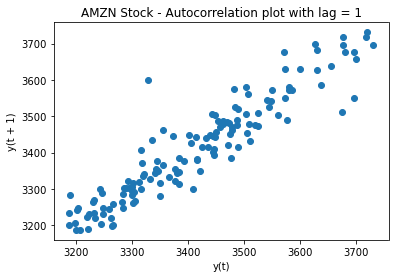

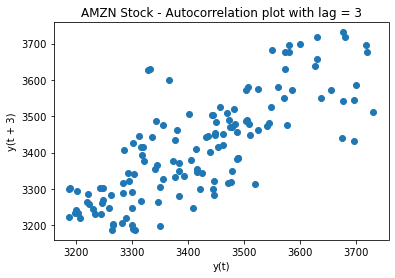

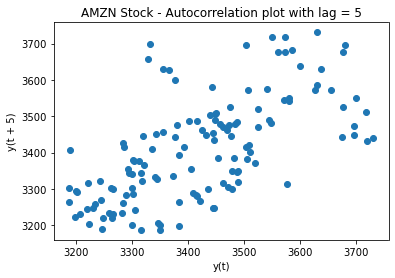

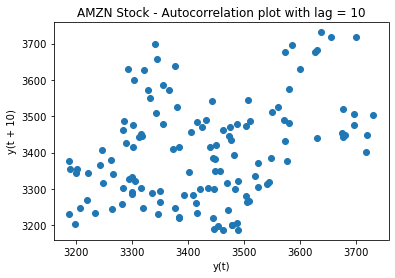

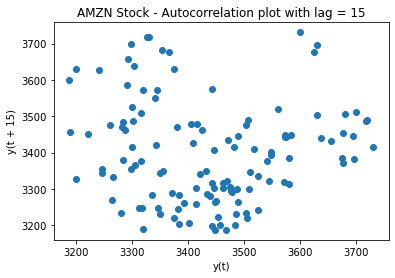

In [21]:
lags = [1, 3, 5, 10, 15]


for lag_ in lags:
    plt.figure()
    lag_plot(amzn_df['Close'], lag=lag_)
    plt.title('AMZN Stock - Autocorrelation plot with lag = '+str(lag_))
    plt.show()

#### Based on the charts above we can concluse that an ARIMA model is correct for our use but lag should remain under 5. I will now look at stationarity using the ADF test. If the p-value > .05 I need to find the order of differencing.

In [22]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(amzn_df.Close)
print(f"ADF Stats: {result[0]} ")
print(f"p-value: {result[1]} ")

ADF Stats: -2.4412193416818972 
p-value: 0.13043881279179148 


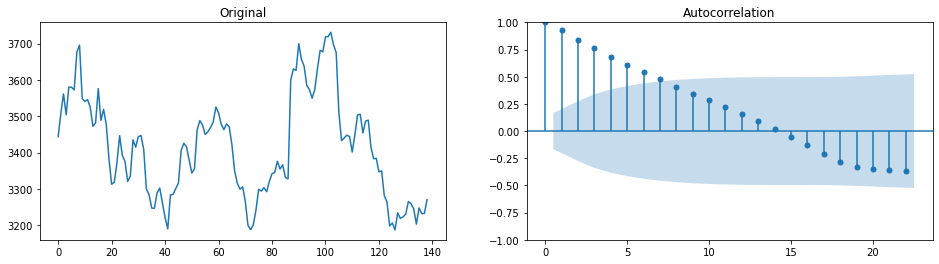

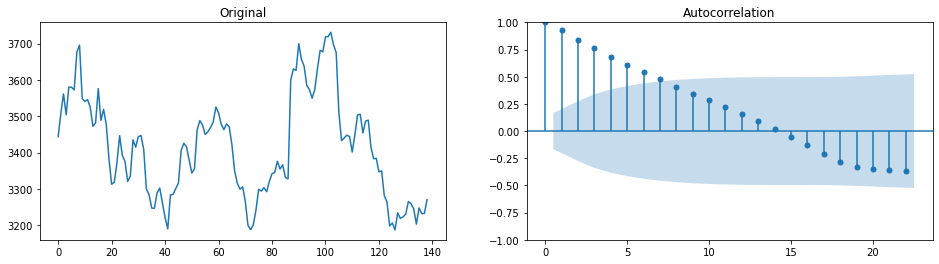

In [23]:
from statsmodels.graphics.tsaplots import plot_acf
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))
ax1.plot(amzn_df.Close)
ax1.set_title('Original')
plot_acf(amzn_df.Close, ax=ax2)

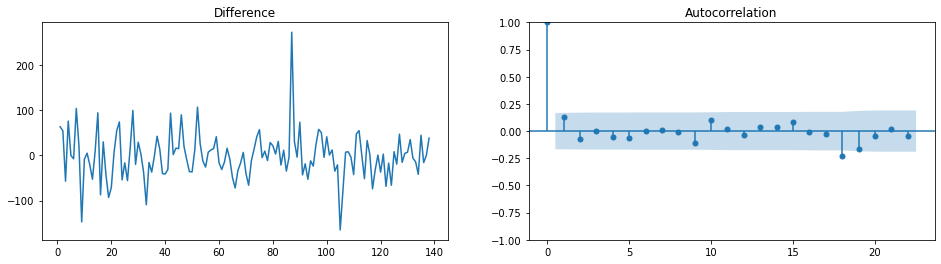

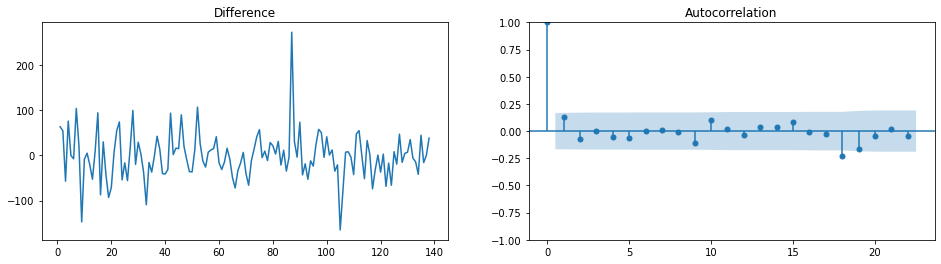

In [24]:
diff = amzn_df.Close.diff().dropna()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

ax1.plot(diff)
ax1.set_title('Difference')
plot_acf(diff, ax=ax2)

# Train Test Split

In [25]:
amzn_df.head()

,Date,Close,High,Change Over Time,Volume
0,2021-12-01,3443.7200,3559.8799,-0.02857,3746074.0
1,2021-11-30,3507.0701,3585.7700,-0.01584,4001205.0
2,2021-11-29,3561.5701,3596.0000,0.00393,3179297.0
3,2021-11-26,3504.5601,3633.5000,-0.02708,2991527.0
4,2021-11-24,3580.4099,3613.0300,0.00498,2328029.0


In [26]:
test_data, train_data = amzn_df[0:int(len(amzn_df)*.7)], \
                            amzn_df[int(len(amzn_df)*.7):]

train = train_data['Close'].values
test = test_data['Close'].values


# Model

In [27]:
train = train_data['Close'].values
test = test_data['Close'].values
# Create list of x train valuess
history = [x for x in train]
# establish list for predictions
model_predictions = []
# Count number of test data points
N_test_observations = len(test)
# loop through every data point
for time_point in range(N_test_observations):
    model = ARIMA(history, order=(5,1,1))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    model_predictions.append(yhat)
    true_test_value = test[time_point]
    history.append(true_test_value)
MAE_error = mean_absolute_error(test, model_predictions).numpy()
print('Testing Mean Absolute Error is {}'.format(MAE_error))



Testing Mean Absolute Error is 41.45525511774787


# Neural Network
- Goal: Make a model that can be saved and make predictions provided with testing data

## First, I will prepare the data. I will be using hourly data to increase predictability. Also, this model will be trained on many stocks.
- First I will construct a working product with a rudimentary list of stocks i.e. less than 20
- Once I've confirmed model validity I will increase the list substantially and investigate performance increases

In [235]:
train_symbols = ['MSFT', 'AMZN', 'AAPL', 'GE', 'F', 'TSLA', 'PG', 'JNJ',
                'ZM', 'GOOG', 'MGM', 'FB', 'AAL', 'PFE', 'CCL',
                'BAC']

In [236]:
final_train_df = build_general_model_hourly_prediction_df('BNTX')[2]

In [237]:
for sym in train_symbols:
    df = build_general_model_hourly_prediction_df(sym)[2]
    print(sym)
    print(df.shape[0])
    final_train_df = final_train_df.append(df)

MSFT
363
AMZN
437
AAPL
276
GE
438
F
298
TSLA
290
PG
438
JNJ
437
ZM
437
GOOG
436
MGM
438
FB
351
AAL
325
PFE
361
CCL
318
BAC
382


In [238]:
final_train_df.shape

(6459, 14)

In [239]:
final_train_df.reset_index(drop = True, inplace = True)

In [240]:
final_train_df

,Close_1hour,Close_2hour,Close_3hour,High_1hour,High_2hour,High_3hour,Low_1hour,Low_2hour,Low_3hour,Vol_1hour,Vol_2hour,Vol_3hour,value,Time
0,325.4750,329.8200,330.6499,329.9565,335.00,334.90,319.850,323.2300,328.0200,533987,827985,8250,326.7286,2021-12-02 12:00:00
1,329.8200,330.6499,334.3800,335.0000,334.90,340.49,323.230,328.0200,334.0700,827985,8250,545824,325.4750,2021-12-02 11:00:00
2,330.6499,334.3800,340.0900,334.9000,340.49,346.80,328.020,334.0700,338.2200,8250,545824,286788,329.8200,2021-12-02 10:00:00
3,334.3800,340.0900,345.9200,340.4900,346.80,346.75,334.070,338.2200,334.5773,545824,286788,489895,330.6499,2021-12-01 16:00:00
4,340.0900,345.9200,334.7800,346.8000,346.75,341.52,338.220,334.5773,334.1400,286788,489895,368506,334.3800,2021-12-01 15:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6454,40.5250,40.2658,40.1500,40.5300,40.61,40.19,40.230,40.1950,40.1000,3759163,5788753,732373,40.5600,2021-09-16 12:00:00
6455,40.2658,40.1500,40.1500,40.6100,40.19,40.34,40.195,40.1000,40.1050,5788753,732373,8933691,40.5250,2021-09-16 11:00:00
6456,40.1500,40.1500,40.1250,40.1900,40.34,40.20,40.100,40.1050,40.0800,732373,8933691,3755442,40.2658,2021-09-16 10:00:00
6457,40.1500,40.1250,40.1623,40.3400,40.20,40.27,40.105,40.0800,40.1300,8933691,3755442,3593187,40.1500,2021-09-15 16:00:00


#### - Now, I will scale the data and add it to the model
#### - I will split the data into only a train and validation set because I can extract an unseen test set right before model validation. The validation split will help train the neural network.

### Train Test Split

In [328]:
X = final_train_df.drop(columns = ['Time', 'value'])
y = final_train_df['value']

#y = np.array(y).reshape(-1, 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3)

### Scale

In [329]:
sc = StandardScaler()
special_sc = StandardScaler()
X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.transform(X_test)

# y_train_scaled = special_sc.fit_transform(y_train)
# y_test_scaled = special_sc.transform(y_test)

In [331]:
X_train_scaled = np.array(X_train_scaled).reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test_scaled = np.array(X_test_scaled).reshape(X_test.shape[0],X_test.shape[1] , 1)



### Model Construction

In [37]:
from keras import layers
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
from keras.metrics import mean_absolute_error

In [38]:
#pip install -U numpy==1.19.2

In [332]:
model = Sequential()
#Adding the first LSTM layer and some Dropout regularisation
model.add(Dense(units = 50, input_shape = (X_train_scaled.shape[1], 1)))
model.add(Dense(units = 100, activation = 'relu'))
model.add(Dropout(0.1))
model.add(Dense(units = 1, activation = 'relu'))

# Compiling the RNN
model.compile(optimizer = 'adam', loss = 'mean_squared_error', 
             metrics=['mean_absolute_error'])

# Fitting the RNN to the Training set
history = model.fit(X_train_scaled, y_train, epochs = 850, batch_size = 32,
         validation_data = (X_test_scaled, y_test),  
        callbacks=[EarlyStopping(patience=50, restore_best_weights=True)])





Epoch 1/850
142/142 [==============================] - 0s 3ms/step - loss: 1376502.3750 - mean_absolute_error: 576.3963 - val_loss: 1426083.6250 - val_mean_absolute_error: 585.4094
Epoch 2/850
142/142 [==============================] - 0s 2ms/step - loss: 1204406.5000 - mean_absolute_error: 529.8461 - val_loss: 1070188.2500 - val_mean_absolute_error: 495.1852
Epoch 3/850
142/142 [==============================] - 0s 2ms/step - loss: 707499.9375 - mean_absolute_error: 415.0811 - val_loss: 573052.9375 - val_mean_absolute_error: 407.5687
Epoch 4/850
142/142 [==============================] - 0s 2ms/step - loss: 556860.1250 - mean_absolute_error: 391.7810 - val_loss: 565675.1250 - val_mean_absolute_error: 395.1577
Epoch 5/850
142/142 [==============================] - 0s 2ms/step - loss: 556238.8750 - mean_absolute_error: 383.2910 - val_loss: 564182.9375 - val_mean_absolute_error: 390.9247
Epoch 6/850
142/142 [==============================] - 0s 2ms/step - loss: 556943.7500 - mean_absolut

142/142 [==============================] - 0s 2ms/step - loss: 557204.7500 - mean_absolute_error: 381.0324 - val_loss: 563588.0000 - val_mean_absolute_error: 389.5937
Epoch 47/850
142/142 [==============================] - 0s 2ms/step - loss: 556309.3125 - mean_absolute_error: 378.9579 - val_loss: 563679.9375 - val_mean_absolute_error: 387.6329
Epoch 48/850
142/142 [==============================] - 0s 2ms/step - loss: 556811.7500 - mean_absolute_error: 378.3676 - val_loss: 563497.8750 - val_mean_absolute_error: 388.8536
Epoch 49/850
142/142 [==============================] - 0s 1ms/step - loss: 556220.3125 - mean_absolute_error: 381.4604 - val_loss: 564438.5000 - val_mean_absolute_error: 389.2052
Epoch 50/850
142/142 [==============================] - 0s 2ms/step - loss: 557012.3750 - mean_absolute_error: 380.9215 - val_loss: 564641.9375 - val_mean_absolute_error: 387.3600
Epoch 51/850
142/142 [==============================] - 0s 2ms/step - loss: 556200.6250 - mean_absolute_error: 37

# Model Validation
- Get unseen test data
- Predict on unseen test data
- Plot on unseen data comparing prediction to actuals
- Once confirmed, pipeline model so that data is inputted, scaled, and predict with the saved model.

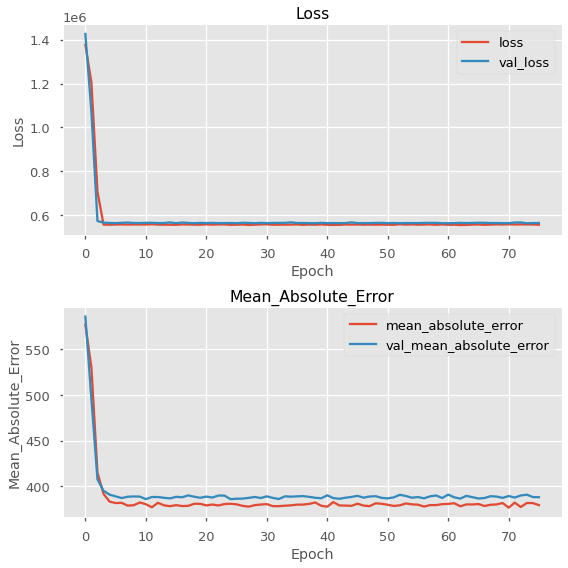

In [333]:
plot_history(history)

In [334]:
test_df = build_general_model_hourly_prediction_df('UBER')[2]

In [335]:
test_df.head(2)

,Close_1hour,Close_2hour,Close_3hour,High_1hour,High_2hour,High_3hour,Low_1hour,Low_2hour,Low_3hour,Vol_1hour,Vol_2hour,Vol_3hour,value,Time
0,38.19,37.83,37.78,38.37,37.96,38.30,37.66,37.46,37.12,3466715,3252204,5949831,37.96,2021-12-02 13:00:00
1,37.83,37.78,36.20,37.96,38.30,36.25,37.46,37.12,36.00,3252204,5949831,3324785,38.19,2021-12-02 12:00:00


In [336]:
X = test_df.drop(columns = ['value', 'Time'])
y = test_df['value']

sc = StandardScaler()

X_scaled = sc.fit_transform(X)

X = np.array(X_scaled).reshape(X.shape[0],X.shape[1] , 1)

In [337]:
preds = model.predict(X)

In [338]:
len(X), len(y), len(preds)

(385, 385, 385)

In [340]:
preds.shape

(385, 12, 1)

In [339]:
y.shape

(385,)

In [343]:
y[0]

37.96

In [354]:
ys = []
for prediction in preds:
    ys.append(np.mean(prediction))

In [341]:
#data3 = np.arange(4620).reshape(52, 2352 )

preds = preds.reshape(y.shape)
preds = pd.Series(preds)

ValueError: cannot reshape array of size 4620 into shape (385,)

In [356]:
time_2 = list(test_df.Time)
time = list(test_df.Time)
time_combined = time_2 + time
combined_data = list(ys)+list(y)

In [357]:
eval_df = pd.DataFrame(columns = ['price', 'category', 'time'])
eval_df.time = time_combined
eval_df.price = combined_data

In [358]:
idx = 0
for cat in eval_df.category:
    if idx < X.shape[0]:
        eval_df.category[idx] = 'prediction'
    else:
        eval_df.category[idx] = 'actual_price'
    idx += 1

In [359]:
eval_df.head(3)

,price,category,time
0,239.755020,prediction,2021-12-02 13:00:00
1,236.206848,prediction,2021-12-02 12:00:00
2,386.716705,prediction,2021-12-02 11:00:00


In [363]:
print('MAE is '+str(np.sqrt(mean_squared_error(y, ys))))

MAE is 733.6077189707258


In [364]:
fig = px.line(eval_df, x='time', y='price', color='category', markers=True, 
             title = 'Actual Stock Price VS Predicted Stock Price Over Time')
fig.update_layout(
   
    yaxis_title="Stock Price",
    font=dict(
        family="Courier New, monospace",
        size=18,
        color="RebeccaPurple"
    )
)

fig.show()

#### It's clear that the model is over predicting because the training label data has such a wide range. To mitigate this I will develop models based on price ranges. To determine these range I will see what distribution of stock prices looks like. 

In [52]:
all_symbols = fmpsdk.available_traded_list(apikey)

In [53]:
len(all_symbols)

31853

In [54]:
type(all_symbols)

list

In [55]:
all_symbols[0]

{'symbol': 'SPY',
 'name': 'SPDR S&P 500 ETF Trust',
 'price': 453.46,
 'exchange': 'New York Stock Exchange Arca',
 'exchangeShortName': 'AMEX'}

In [56]:
price_list = []
for symbol in all_symbols:
    price_list.append(symbol['price'])

In [57]:
print('Average stock price')
np.mean(price_list)

Average stock price


1787.2566213543464

In [58]:
print('Median Stock Price')
np.median(price_list)

Median Stock Price


24.42

In [59]:
count = 0
for price in price_list:
    if price > 1000:
        count +=1
print('There are '+str(count)+' stocks above $1000')
percent = count / len(price_list)
print('Which is '+str(percent*100)+'% of the total')

There are 2526 stocks above $1000
Which is 7.930179260980127% of the total


In [60]:
count = 0
for price in price_list:
    if price > 1500:
        count +=1
print('There are '+str(count)+' stocks above $1500')
percent = count / len(price_list)
print('Which is '+str(percent*100)+'% of the total')

There are 2046 stocks above $1500
Which is 6.423256836090792% of the total


In [61]:
count = 0
for price in price_list:
    if price > 500:
        count +=1
print('There are '+str(count)+' stocks above $500')
percent = count / len(price_list)
print('Which is '+str(percent*100)+'% of the total')

There are 3411 stocks above $500
Which is 10.708567481869839% of the total


In [62]:
count = 0
for price in price_list:
    if price < 10:
        count +=1
print('There are '+str(count)+' stocks less than $10')
percent = count / len(price_list)
print('Which is '+str(percent*100)+'% of the total')

There are 9914 stocks less than $10
Which is 31.124226917401813% of the total


#### First, I will make a model that is in the range 0-10. This network will be called the penny stock lstm.

In [63]:
penny_symbols = []
for symbol in all_symbols:
    if symbol['price'] < 10:
        penny_symbols.append(symbol['symbol'])

In [64]:
len(penny_symbols)

9914

In [65]:
penny_train_df = build_general_model_hourly_prediction_df(
                        penny_symbols[1])[2]

counter = 0
for sym in penny_symbols[250:300]:
    counter += 1
    print(counter)
    df = build_general_model_hourly_prediction_df(sym)[2]
    penny_train_df = penny_train_df.append(df)
penny_train_df.reset_index(drop = True, inplace = True)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50


In [66]:
X = penny_train_df.drop(columns = ['Time', 'value'])
y = penny_train_df['value']

y = np.array(y).reshape(-1, 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3)


sc = StandardScaler()
special_sc = StandardScaler()
X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.transform(X_test)

In [67]:
X_train_scaled = np.array(X_train_scaled).reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test_scaled = np.array(X_test_scaled).reshape(X_test.shape[0],X_test.shape[1] , 1)



penny_model = Sequential()
#Adding the first LSTM layer and some Dropout regularisation
penny_model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train_scaled.shape[1], 1)))
penny_model.add(Dropout(0.2))
# Adding a second LSTM layer and some Dropout regularisation
penny_model.add(LSTM(units = 50, return_sequences = True))
penny_model.add(Dropout(0.2))
# Adding a third LSTM layer and some Dropout regularisation
penny_model.add(LSTM(units = 50, return_sequences = True))
penny_model.add(Dropout(0.2))
# Adding a fourth LSTM layer and some Dropout regularisation
penny_model.add(LSTM(units = 50))
penny_model.add(Dropout(0.2))
# Adding the output layer
penny_model.add(Dense(units = 1))

# Compiling the RNN
penny_model.compile(optimizer = 'adam', loss = 'mean_squared_error', 
             metrics=['mean_absolute_error'])

# Fitting the RNN to the Training set
penny_history = penny_model.fit(X_train_scaled, y_train, epochs = 400, batch_size = 32,
         validation_data = (X_test_scaled, y_test),  
        callbacks=[EarlyStopping(patience=25, restore_best_weights=True)])




Epoch 1/400
463/463 [==============================] - 10s 21ms/step - loss: 2.4750 - mean_absolute_error: 0.8368 - val_loss: 0.1189 - val_mean_absolute_error: 0.1814
Epoch 2/400
463/463 [==============================] - 8s 17ms/step - loss: 0.3568 - mean_absolute_error: 0.4372 - val_loss: 0.0915 - val_mean_absolute_error: 0.2012
Epoch 3/400
463/463 [==============================] - 7s 16ms/step - loss: 0.3212 - mean_absolute_error: 0.4159 - val_loss: 0.1033 - val_mean_absolute_error: 0.2559
Epoch 4/400
463/463 [==============================] - 9s 20ms/step - loss: 0.3021 - mean_absolute_error: 0.4040 - val_loss: 0.0446 - val_mean_absolute_error: 0.1255
Epoch 5/400
463/463 [==============================] - 9s 20ms/step - loss: 0.2886 - mean_absolute_error: 0.3967 - val_loss: 0.0446 - val_mean_absolute_error: 0.1327
Epoch 6/400
463/463 [==============================] - 7s 16ms/step - loss: 0.2761 - mean_absolute_error: 0.3844 - val_loss: 0.0681 - val_mean_absolute_error: 0.1881
Epo

463/463 [==============================] - 7s 15ms/step - loss: 0.1007 - mean_absolute_error: 0.2216 - val_loss: 0.0271 - val_mean_absolute_error: 0.1039
Epoch 51/400
463/463 [==============================] - 7s 16ms/step - loss: 0.1044 - mean_absolute_error: 0.2212 - val_loss: 0.0197 - val_mean_absolute_error: 0.0720
Epoch 52/400
463/463 [==============================] - 7s 15ms/step - loss: 0.0969 - mean_absolute_error: 0.2174 - val_loss: 0.0249 - val_mean_absolute_error: 0.0966
Epoch 53/400
463/463 [==============================] - 7s 15ms/step - loss: 0.0948 - mean_absolute_error: 0.2144 - val_loss: 0.0197 - val_mean_absolute_error: 0.0710
Epoch 54/400
463/463 [==============================] - 7s 15ms/step - loss: 0.0919 - mean_absolute_error: 0.2124 - val_loss: 0.0277 - val_mean_absolute_error: 0.1015
Epoch 55/400
463/463 [==============================] - 8s 16ms/step - loss: 0.0949 - mean_absolute_error: 0.2139 - val_loss: 0.0208 - val_mean_absolute_error: 0.0791
Epoch 56/40

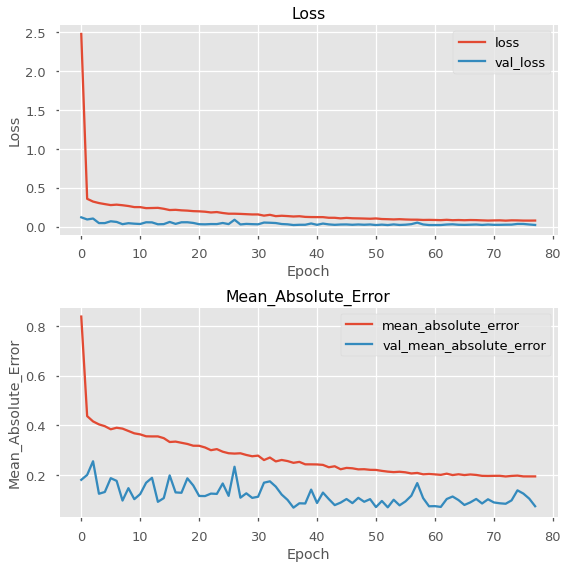

In [68]:
plot_history(penny_history)

In [69]:
penny_symbols[1200]

'SGLBW'

In [70]:
test_df = build_general_model_hourly_prediction_df(penny_symbols[1200])[2]

X = test_df.drop(columns = ['value', 'Time'])
y = test_df['value']

sc = StandardScaler()

X_scaled = sc.fit_transform(X)

X = np.array(X_scaled).reshape(X.shape[0],X.shape[1] , 1)

In [71]:
preds = penny_model.predict(X)

preds = preds.reshape(y.shape)
preds = pd.Series(preds)



time_2 = list(test_df.Time)
time = list(test_df.Time)
time_combined = time_2 + time
combined_data = list(preds)+list(y)




eval_df = pd.DataFrame(columns = ['data', 'category', 'time'])
eval_df.time = time_combined
eval_df.data = combined_data






idx = 0
for cat in eval_df.category:
    if idx < X.shape[0]:
        eval_df.category[idx] = 'prediction'
    else:
        eval_df.category[idx] = 'actual_price'
    idx += 1

In [72]:
print('MAE is '+str(np.sqrt(mean_squared_error(y, preds))))

MAE is 6.370351596223264


In [73]:
fig = px.line(eval_df, x='time', y='data', color='category', markers=True, 
             title = 'Actual Stock Price VS Predicted Stock Price Over Time')
fig.update_layout(
   
    yaxis_title="Stock Price",
    font=dict(
        family="Courier New, monospace",
        size=18,
        color="RebeccaPurple"
    )
)

fig.show()

#### This already looks much closer than the previous model. Because penny stocks make up 31% of the total, I will start by making two additional models that will make up the rest. The first model will be called the meh_stock_model. The meh_stock_model will be trained on stocks between 10-50 dollars.

In [74]:
count = 0
for price in price_list:
    if (price > 10) & (price <50):
        count +=1
print('There are '+str(count)+' stocks greater than $10 but less than $50')
percent = count / len(price_list)
print('Which is '+str(percent*100)+'% of the total')

There are 11538 stocks greater than $10 but less than $50
Which is 36.2226477882774% of the total


In [75]:
count = 0
for price in price_list:
    if price > 50:
        count +=1
print('There are '+str(count)+' stocks greater than $50')
percent = count / len(price_list)
print('Which is '+str(percent*100)+'% of the total')

There are 10343 stocks greater than $50
Which is 32.47103883464666% of the total


In [76]:
meh_symbols = []
for symbol in all_symbols:
    if (symbol['price'] > 10) & (symbol['price'] < 50):
        meh_symbols.append(symbol['symbol'])

In [77]:
len(meh_symbols)

11538

In [78]:
meh_train_df = build_general_model_hourly_prediction_df(
                        meh_symbols[1])[2]

counter = 0
for sym in meh_symbols[250:300]:
    counter += 1
    print(counter)
    df = build_general_model_hourly_prediction_df(sym)[2]
    meh_train_df = meh_train_df.append(df)
meh_train_df.reset_index(drop = True, inplace = True)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50


In [79]:
X = meh_train_df.drop(columns = ['Time', 'value'])
y = meh_train_df['value']

y = np.array(y).reshape(-1, 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3)


sc = StandardScaler()
special_sc = StandardScaler()
X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.transform(X_test)

In [80]:
X_train_scaled = np.array(X_train_scaled).reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test_scaled = np.array(X_test_scaled).reshape(X_test.shape[0],X_test.shape[1] , 1)



meh_model = Sequential()
#Adding the first LSTM layer and some Dropout regularisation
meh_model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train_scaled.shape[1], 1)))
meh_model.add(Dropout(0.2))
# Adding a second LSTM layer and some Dropout regularisation
meh_model.add(LSTM(units = 50, return_sequences = True))
meh_model.add(Dropout(0.2))
# Adding a third LSTM layer and some Dropout regularisation
meh_model.add(LSTM(units = 50, return_sequences = True))
meh_model.add(Dropout(0.2))
# Adding a fourth LSTM layer and some Dropout regularisation
meh_model.add(LSTM(units = 50))
meh_model.add(Dropout(0.2))
# Adding the output layer
meh_model.add(Dense(units = 1))

# Compiling the RNN
meh_model.compile(optimizer = 'adam', loss = 'mean_squared_error', 
             metrics=['mean_absolute_error'])

# Fitting the RNN to the Training set
meh_history = meh_model.fit(X_train_scaled, y_train, epochs = 400, batch_size = 32,
         validation_data = (X_test_scaled, y_test),  
        callbacks=[EarlyStopping(patience=25, restore_best_weights=True)])


Epoch 1/400
474/474 [==============================] - 10s 20ms/step - loss: 263.6032 - mean_absolute_error: 12.5557 - val_loss: 140.7125 - val_mean_absolute_error: 9.5050
Epoch 2/400
474/474 [==============================] - 8s 16ms/step - loss: 136.9731 - mean_absolute_error: 9.6401 - val_loss: 133.2814 - val_mean_absolute_error: 9.6648
Epoch 3/400
474/474 [==============================] - 8s 16ms/step - loss: 135.3472 - mean_absolute_error: 9.7156 - val_loss: 132.8730 - val_mean_absolute_error: 9.6448
Epoch 4/400
474/474 [==============================] - 8s 17ms/step - loss: 47.3892 - mean_absolute_error: 4.3732 - val_loss: 13.1695 - val_mean_absolute_error: 2.3039
Epoch 5/400
474/474 [==============================] - 8s 16ms/step - loss: 10.7240 - mean_absolute_error: 2.1993 - val_loss: 3.2110 - val_mean_absolute_error: 1.0542
Epoch 6/400
474/474 [==============================] - 8s 16ms/step - loss: 6.7942 - mean_absolute_error: 1.8779 - val_loss: 1.1168 - val_mean_absolute_e

474/474 [==============================] - 8s 16ms/step - loss: 3.4852 - mean_absolute_error: 1.3544 - val_loss: 0.6092 - val_mean_absolute_error: 0.6707
Epoch 51/400
474/474 [==============================] - 8s 16ms/step - loss: 3.4750 - mean_absolute_error: 1.3494 - val_loss: 0.2453 - val_mean_absolute_error: 0.3867
Epoch 52/400
474/474 [==============================] - 8s 16ms/step - loss: 3.4932 - mean_absolute_error: 1.3593 - val_loss: 0.1309 - val_mean_absolute_error: 0.2579
Epoch 53/400
474/474 [==============================] - 8s 16ms/step - loss: 3.3488 - mean_absolute_error: 1.3217 - val_loss: 0.1981 - val_mean_absolute_error: 0.3378
Epoch 54/400
474/474 [==============================] - 8s 16ms/step - loss: 3.3500 - mean_absolute_error: 1.3263 - val_loss: 0.5393 - val_mean_absolute_error: 0.5973
Epoch 55/400
474/474 [==============================] - 8s 16ms/step - loss: 3.3088 - mean_absolute_error: 1.3264 - val_loss: 0.1745 - val_mean_absolute_error: 0.3281
Epoch 56/40

In [81]:
meh_symbols[1200]

'AMTX'

In [82]:
test_df = build_general_model_hourly_prediction_df(meh_symbols[1200])[2]

X = test_df.drop(columns = ['value', 'Time'])
y = test_df['value']

sc = StandardScaler()

X_scaled = sc.fit_transform(X)

X = np.array(X_scaled).reshape(X.shape[0],X.shape[1] , 1)

In [83]:
preds = meh_model.predict(X)

preds = preds.reshape(y.shape)
preds = pd.Series(preds)



time_2 = list(test_df.Time)
time = list(test_df.Time)
time_combined = time_2 + time
combined_data = list(preds)+list(y)




eval_df = pd.DataFrame(columns = ['price', 'category', 'time'])
eval_df.time = time_combined
eval_df.price = combined_data






idx = 0
for cat in eval_df.category:
    if idx < X.shape[0]:
        eval_df.category[idx] = 'prediction'
    else:
        eval_df.category[idx] = 'actual_price'
    idx += 1

In [84]:
fig = px.line(eval_df, x='time', y='price', color='category', markers=True, 
             title = 'Actual Stock Price VS Predicted Stock Price Over Time')
fig.update_layout(
   
    yaxis_title="Stock Price",
    font=dict(
        family="Courier New, monospace",
        size=18,
        color="RebeccaPurple"
    )
)

fig.show()

In [85]:
print('MAE is '+str(np.sqrt(mean_squared_error(y, preds))))

MAE is 13.214826990018576


#### The last model will make up stocks that are greater than $50 and will be called the phat_model.

In [86]:
phat_symbols = []
for symbol in all_symbols:
    if symbol['price'] > 50:
        phat_symbols.append(symbol['symbol'])

In [87]:
len(phat_symbols)

10343

In [88]:
phat_train_df = build_general_model_hourly_prediction_df(
                        phat_symbols[1])[2]

counter = 0
for sym in phat_symbols[250:300]:
    counter += 1
    print(counter)
    df = build_general_model_hourly_prediction_df(sym)[2]
    phat_train_df = phat_train_df.append(df)
phat_train_df.reset_index(drop = True, inplace = True)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50


In [89]:
X = phat_train_df.drop(columns = ['Time', 'value'])
y = phat_train_df['value']

y = np.array(y).reshape(-1, 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3)


sc = StandardScaler()
special_sc = StandardScaler()
X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.transform(X_test)

In [90]:
X_train_scaled = np.array(X_train_scaled).reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test_scaled = np.array(X_test_scaled).reshape(X_test.shape[0],X_test.shape[1] , 1)



phat_model = Sequential()
#Adding the first LSTM layer and some Dropout regularisation
phat_model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train_scaled.shape[1], 1)))
phat_model.add(Dropout(0.2))
# Adding a second LSTM layer and some Dropout regularisation
phat_model.add(LSTM(units = 50, return_sequences = True))
phat_model.add(Dropout(0.2))
# Adding a third LSTM layer and some Dropout regularisation
phat_model.add(LSTM(units = 50, return_sequences = True))
phat_model.add(Dropout(0.2))
# Adding a fourth LSTM layer and some Dropout regularisation
phat_model.add(LSTM(units = 50))
phat_model.add(Dropout(0.2))
# Adding the output layer
phat_model.add(Dense(units = 1))

# Compiling the RNN
phat_model.compile(optimizer = 'adam', loss = 'mean_squared_error', 
             metrics=['mean_absolute_error'])

# Fitting the RNN to the Training set
phat_history = phat_model.fit(X_train_scaled, y_train, epochs = 400, batch_size = 32,
         validation_data = (X_test_scaled, y_test),  
        callbacks=[EarlyStopping(patience=25, restore_best_weights=True)])


Epoch 1/400
478/478 [==============================] - 9s 19ms/step - loss: 196720.3594 - mean_absolute_error: 189.7886 - val_loss: 183403.3750 - val_mean_absolute_error: 176.1658
Epoch 2/400
478/478 [==============================] - 8s 16ms/step - loss: 188739.4219 - mean_absolute_error: 167.6229 - val_loss: 176552.0469 - val_mean_absolute_error: 155.6372
Epoch 3/400
478/478 [==============================] - 8s 17ms/step - loss: 182393.9219 - mean_absolute_error: 149.3524 - val_loss: 170967.8125 - val_mean_absolute_error: 140.5611
Epoch 4/400
478/478 [==============================] - 8s 16ms/step - loss: 177384.3281 - mean_absolute_error: 138.1250 - val_loss: 166418.0625 - val_mean_absolute_error: 133.2008
Epoch 5/400
478/478 [==============================] - 8s 17ms/step - loss: 173187.0781 - mean_absolute_error: 133.0635 - val_loss: 162766.1250 - val_mean_absolute_error: 130.1719
Epoch 6/400
478/478 [==============================] - 8s 16ms/step - loss: 169914.3750 - mean_absol

Epoch 47/400
478/478 [==============================] - 8s 16ms/step - loss: 93371.9375 - mean_absolute_error: 52.5631 - val_loss: 86808.1875 - val_mean_absolute_error: 43.1981
Epoch 48/400
478/478 [==============================] - 8s 16ms/step - loss: 92865.5234 - mean_absolute_error: 52.4091 - val_loss: 85728.3281 - val_mean_absolute_error: 43.7523
Epoch 49/400
478/478 [==============================] - 8s 17ms/step - loss: 90852.9375 - mean_absolute_error: 51.9502 - val_loss: 84595.1406 - val_mean_absolute_error: 43.5240
Epoch 50/400
478/478 [==============================] - 8s 16ms/step - loss: 89865.3281 - mean_absolute_error: 51.6515 - val_loss: 83502.9922 - val_mean_absolute_error: 45.3457
Epoch 51/400
478/478 [==============================] - 7s 16ms/step - loss: 88450.0859 - mean_absolute_error: 51.1739 - val_loss: 82389.3750 - val_mean_absolute_error: 43.1482
Epoch 52/400
478/478 [==============================] - 8s 16ms/step - loss: 87183.1484 - mean_absolute_error: 51.0

478/478 [==============================] - 13s 26ms/step - loss: 46701.3867 - mean_absolute_error: 38.7817 - val_loss: 42961.7734 - val_mean_absolute_error: 31.7501
Epoch 94/400
478/478 [==============================] - 9s 19ms/step - loss: 45568.7617 - mean_absolute_error: 38.4277 - val_loss: 42171.2812 - val_mean_absolute_error: 31.3175
Epoch 95/400
478/478 [==============================] - 9s 18ms/step - loss: 45008.2461 - mean_absolute_error: 38.2914 - val_loss: 41386.3945 - val_mean_absolute_error: 29.9235
Epoch 96/400
478/478 [==============================] - 10s 20ms/step - loss: 44227.6055 - mean_absolute_error: 37.9684 - val_loss: 40657.6094 - val_mean_absolute_error: 33.7043
Epoch 97/400
478/478 [==============================] - 10s 21ms/step - loss: 43596.1016 - mean_absolute_error: 37.7595 - val_loss: 39882.1133 - val_mean_absolute_error: 31.5410
Epoch 98/400
478/478 [==============================] - 9s 20ms/step - loss: 42771.3945 - mean_absolute_error: 37.4866 - val_

478/478 [==============================] - 9s 19ms/step - loss: 16540.3789 - mean_absolute_error: 25.0980 - val_loss: 14603.4883 - val_mean_absolute_error: 20.2440
Epoch 140/400
478/478 [==============================] - 9s 19ms/step - loss: 15840.4648 - mean_absolute_error: 24.9136 - val_loss: 14151.7461 - val_mean_absolute_error: 19.4528
Epoch 141/400
478/478 [==============================] - 9s 18ms/step - loss: 15986.2100 - mean_absolute_error: 25.0892 - val_loss: 13719.8232 - val_mean_absolute_error: 20.1932
Epoch 142/400
478/478 [==============================] - 9s 18ms/step - loss: 15171.4492 - mean_absolute_error: 24.3799 - val_loss: 13287.1943 - val_mean_absolute_error: 18.3393
Epoch 143/400
478/478 [==============================] - 9s 18ms/step - loss: 14543.9492 - mean_absolute_error: 23.8651 - val_loss: 12872.0449 - val_mean_absolute_error: 17.6626
Epoch 144/400
478/478 [==============================] - 9s 18ms/step - loss: 14498.7373 - mean_absolute_error: 23.8933 - va

478/478 [==============================] - 9s 19ms/step - loss: 2757.6177 - mean_absolute_error: 12.8667 - val_loss: 1693.2136 - val_mean_absolute_error: 7.8635
Epoch 186/400
478/478 [==============================] - 10s 20ms/step - loss: 2543.4001 - mean_absolute_error: 12.4637 - val_loss: 1566.7330 - val_mean_absolute_error: 7.0264
Epoch 187/400
478/478 [==============================] - 10s 21ms/step - loss: 2492.9614 - mean_absolute_error: 12.4668 - val_loss: 1449.1776 - val_mean_absolute_error: 6.9352
Epoch 188/400
478/478 [==============================] - 9s 20ms/step - loss: 72066.3984 - mean_absolute_error: 35.5781 - val_loss: 1429.9468 - val_mean_absolute_error: 7.0578
Epoch 189/400
478/478 [==============================] - 10s 21ms/step - loss: 2566.0806 - mean_absolute_error: 12.8257 - val_loss: 1353.1691 - val_mean_absolute_error: 6.3177
Epoch 190/400
478/478 [==============================] - 9s 19ms/step - loss: 2248.4973 - mean_absolute_error: 12.0422 - val_loss: 1294

Epoch 232/400
478/478 [==============================] - 11s 24ms/step - loss: 1185.4210 - mean_absolute_error: 10.1662 - val_loss: 181.0627 - val_mean_absolute_error: 5.8677
Epoch 233/400
478/478 [==============================] - 12s 25ms/step - loss: 1092.7428 - mean_absolute_error: 9.9497 - val_loss: 149.8531 - val_mean_absolute_error: 2.5500
Epoch 234/400
478/478 [==============================] - 12s 25ms/step - loss: 1022.5038 - mean_absolute_error: 9.7633 - val_loss: 149.7188 - val_mean_absolute_error: 2.9876
Epoch 235/400
478/478 [==============================] - 11s 23ms/step - loss: 1205.2885 - mean_absolute_error: 9.9976 - val_loss: 171.5952 - val_mean_absolute_error: 4.2139
Epoch 236/400
478/478 [==============================] - 13s 27ms/step - loss: 1071.8822 - mean_absolute_error: 9.9678 - val_loss: 155.8117 - val_mean_absolute_error: 3.1849
Epoch 237/400
478/478 [==============================] - 12s 25ms/step - loss: 1052.4453 - mean_absolute_error: 9.7501 - val_loss

478/478 [==============================] - 11s 23ms/step - loss: 1186.4618 - mean_absolute_error: 9.8412 - val_loss: 150.6909 - val_mean_absolute_error: 3.8857
Epoch 280/400
478/478 [==============================] - 13s 27ms/step - loss: 1084.8644 - mean_absolute_error: 9.5794 - val_loss: 144.2043 - val_mean_absolute_error: 2.8541
Epoch 281/400
478/478 [==============================] - 13s 28ms/step - loss: 1008.9240 - mean_absolute_error: 9.6021 - val_loss: 145.3353 - val_mean_absolute_error: 3.1094
Epoch 282/400
478/478 [==============================] - 10s 21ms/step - loss: 1040.1140 - mean_absolute_error: 9.8295 - val_loss: 150.2476 - val_mean_absolute_error: 2.7804
Epoch 283/400
478/478 [==============================] - 10s 20ms/step - loss: 1089.3784 - mean_absolute_error: 9.6542 - val_loss: 144.0954 - val_mean_absolute_error: 3.1058
Epoch 284/400
478/478 [==============================] - 10s 21ms/step - loss: 1063.7281 - mean_absolute_error: 9.6802 - val_loss: 147.4352 - va

In [91]:
phat_symbols[1200]

'DDM'

In [92]:
test_df = build_general_model_hourly_prediction_df(phat_symbols[1200])[2]

X = test_df.drop(columns = ['value', 'Time'])
y = test_df['value']

sc = StandardScaler()

X_scaled = sc.fit_transform(X)

X = np.array(X_scaled).reshape(X.shape[0],X.shape[1] , 1)

In [93]:
preds = phat_model.predict(X)

preds = preds.reshape(y.shape)
preds = pd.Series(preds)



time_2 = list(test_df.Time)
time = list(test_df.Time)
time_combined = time_2 + time
combined_data = list(preds)+list(y)




eval_df = pd.DataFrame(columns = ['price', 'category', 'time'])
eval_df.time = time_combined
eval_df.price = combined_data






idx = 0
for cat in eval_df.category:
    if idx < X.shape[0]:
        eval_df.category[idx] = 'prediction'
    else:
        eval_df.category[idx] = 'actual_price'
    idx += 1

In [94]:
print('MAE is '+str(np.sqrt(mean_squared_error(y, preds))))

MAE is 362.7436213109867


In [95]:
fig = px.line(eval_df, x='time', y='price', color='category', markers=True, 
             title = 'Actual Stock Price VS Predicted Stock Price Over Time')
fig.update_layout(
   
    yaxis_title="Stock Price",
    font=dict(
        family="Courier New, monospace",
        size=18,
        color="RebeccaPurple"
    )
)

fig.show()

#### Now I will see how a network does when trained on an individual stock.

In [96]:
amzn_df = build_general_model_hourly_prediction_df('AMZN')[2]

In [97]:
amzn_df.shape

(436, 14)

In [98]:
X = amzn_df.drop(columns = ['value', 'Time'])
y = amzn_df['value']

In [99]:
X_train = X[0:350]
X_test = X[350:]

y_train = y[0:350]
y_test = y[350:]

X_val = X_train[250:]
X_train = X_train[:250]

y_val = y_train[250:]
y_train = y_train[:250]

In [100]:
sc = StandardScaler()

X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.transform(X_test)
X_val_scaled = sc.transform(X_val)

X_train_scaled = np.array(X_train_scaled).reshape(X_train.shape[0],X_train.shape[1] , 1)

X_test_scaled = np.array(X_test_scaled).reshape(X_test.shape[0], X_test.shape[1], 1)

X_val_scaled = np.array(X_val_scaled).reshape(X_val.shape[0], X_val.shape[1], 1)


In [101]:
amzn_model = Sequential()
#Adding the first LSTM layer and some Dropout regularisation
amzn_model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train_scaled.shape[1], 1)))
amzn_model.add(Dropout(0.2))
# Adding a second LSTM layer and some Dropout regularisation
amzn_model.add(LSTM(units = 50, return_sequences = True))
amzn_model.add(Dropout(0.2))
# Adding a third LSTM layer and some Dropout regularisation
amzn_model.add(LSTM(units = 50, return_sequences = True))
amzn_model.add(Dropout(0.2))
# Adding a fourth LSTM layer and some Dropout regularisation
amzn_model.add(LSTM(units = 50))
amzn_model.add(Dropout(0.2))
# Adding the output layer
amzn_model.add(Dense(units = 1))

# Compiling the RNN
amzn_model.compile(optimizer = 'adam', loss = 'mean_squared_error', 
             metrics=['mean_absolute_error'])

# Fitting the RNN to the Training set
amzn_history = amzn_model.fit(X_train_scaled, y_train, epochs = 400, batch_size = 32,
         validation_data = (X_test_scaled, y_test),  
        callbacks=[EarlyStopping(patience=10, restore_best_weights=True)])


Epoch 1/400
8/8 [==============================] - 1s 172ms/step - loss: 12008049.0000 - mean_absolute_error: 3463.4600 - val_loss: 11954513.0000 - val_mean_absolute_error: 3457.1003
Epoch 2/400
8/8 [==============================] - 0s 22ms/step - loss: 12001279.0000 - mean_absolute_error: 3462.4954 - val_loss: 11940528.0000 - val_mean_absolute_error: 3455.0818
Epoch 3/400
8/8 [==============================] - 0s 23ms/step - loss: 11975274.0000 - mean_absolute_error: 3458.7405 - val_loss: 11906151.0000 - val_mean_absolute_error: 3450.0984
Epoch 4/400
8/8 [==============================] - 0s 21ms/step - loss: 11950563.0000 - mean_absolute_error: 3455.1506 - val_loss: 11891042.0000 - val_mean_absolute_error: 3447.9077
Epoch 5/400
8/8 [==============================] - 0s 22ms/step - loss: 11938922.0000 - mean_absolute_error: 3453.4651 - val_loss: 11882152.0000 - val_mean_absolute_error: 3446.6182
Epoch 6/400
8/8 [==============================] - 0s 22ms/step - loss: 11932151.0000 - m

Epoch 46/400
8/8 [==============================] - 0s 24ms/step - loss: 11804953.0000 - mean_absolute_error: 3434.0073 - val_loss: 11751997.0000 - val_mean_absolute_error: 3427.6846
Epoch 47/400
8/8 [==============================] - 0s 22ms/step - loss: 11801497.0000 - mean_absolute_error: 3433.5120 - val_loss: 11749081.0000 - val_mean_absolute_error: 3427.2590
Epoch 48/400
8/8 [==============================] - 0s 22ms/step - loss: 11799525.0000 - mean_absolute_error: 3433.2200 - val_loss: 11746172.0000 - val_mean_absolute_error: 3426.8350
Epoch 49/400
8/8 [==============================] - 0s 22ms/step - loss: 11796667.0000 - mean_absolute_error: 3432.8059 - val_loss: 11743269.0000 - val_mean_absolute_error: 3426.4114
Epoch 50/400
8/8 [==============================] - 0s 22ms/step - loss: 11793917.0000 - mean_absolute_error: 3432.4060 - val_loss: 11740376.0000 - val_mean_absolute_error: 3425.9890
Epoch 51/400
8/8 [==============================] - 0s 22ms/step - loss: 11788575.000

Epoch 91/400
8/8 [==============================] - 0s 33ms/step - loss: 11679013.0000 - mean_absolute_error: 3415.6309 - val_loss: 11623967.0000 - val_mean_absolute_error: 3408.9578
Epoch 92/400
8/8 [==============================] - 0s 31ms/step - loss: 11673955.0000 - mean_absolute_error: 3414.8911 - val_loss: 11621168.0000 - val_mean_absolute_error: 3408.5471
Epoch 93/400
8/8 [==============================] - 0s 25ms/step - loss: 11669728.0000 - mean_absolute_error: 3414.2747 - val_loss: 11618361.0000 - val_mean_absolute_error: 3408.1353
Epoch 94/400
8/8 [==============================] - 0s 24ms/step - loss: 11669545.0000 - mean_absolute_error: 3414.2485 - val_loss: 11615557.0000 - val_mean_absolute_error: 3407.7239
Epoch 95/400
8/8 [==============================] - 0s 26ms/step - loss: 11667773.0000 - mean_absolute_error: 3413.9785 - val_loss: 11612760.0000 - val_mean_absolute_error: 3407.3132
Epoch 96/400
8/8 [==============================] - 0s 24ms/step - loss: 11662779.000

8/8 [==============================] - 0s 19ms/step - loss: 11552129.0000 - mean_absolute_error: 3396.9834 - val_loss: 11501540.0000 - val_mean_absolute_error: 3390.9534
Epoch 136/400
8/8 [==============================] - 0s 19ms/step - loss: 11548070.0000 - mean_absolute_error: 3396.3984 - val_loss: 11498759.0000 - val_mean_absolute_error: 3390.5432
Epoch 137/400
8/8 [==============================] - 0s 19ms/step - loss: 11550730.0000 - mean_absolute_error: 3396.7903 - val_loss: 11495989.0000 - val_mean_absolute_error: 3390.1345
Epoch 138/400
8/8 [==============================] - 0s 21ms/step - loss: 11545739.0000 - mean_absolute_error: 3396.0466 - val_loss: 11493227.0000 - val_mean_absolute_error: 3389.7275
Epoch 139/400
8/8 [==============================] - 0s 20ms/step - loss: 11543547.0000 - mean_absolute_error: 3395.7324 - val_loss: 11490467.0000 - val_mean_absolute_error: 3389.3201
Epoch 140/400
8/8 [==============================] - 0s 19ms/step - loss: 11542536.0000 - mean

8/8 [==============================] - 0s 18ms/step - loss: 11429791.0000 - mean_absolute_error: 3378.9512 - val_loss: 11380644.0000 - val_mean_absolute_error: 3373.0798
Epoch 180/400
8/8 [==============================] - 0s 17ms/step - loss: 11431908.0000 - mean_absolute_error: 3379.2681 - val_loss: 11377908.0000 - val_mean_absolute_error: 3372.6743
Epoch 181/400
8/8 [==============================] - 0s 17ms/step - loss: 11422982.0000 - mean_absolute_error: 3377.9280 - val_loss: 11375165.0000 - val_mean_absolute_error: 3372.2678
Epoch 182/400
8/8 [==============================] - 0s 17ms/step - loss: 11418316.0000 - mean_absolute_error: 3377.2534 - val_loss: 11372415.0000 - val_mean_absolute_error: 3371.8601
Epoch 183/400
8/8 [==============================] - 0s 17ms/step - loss: 11417526.0000 - mean_absolute_error: 3377.1589 - val_loss: 11369663.0000 - val_mean_absolute_error: 3371.4514
Epoch 184/400
8/8 [==============================] - 0s 18ms/step - loss: 11421479.0000 - mean

8/8 [==============================] - 0s 20ms/step - loss: 11313682.0000 - mean_absolute_error: 3361.7051 - val_loss: 11260757.0000 - val_mean_absolute_error: 3355.2617
Epoch 224/400
8/8 [==============================] - 0s 20ms/step - loss: 11309850.0000 - mean_absolute_error: 3361.1353 - val_loss: 11258044.0000 - val_mean_absolute_error: 3354.8577
Epoch 225/400
8/8 [==============================] - 0s 20ms/step - loss: 11308940.0000 - mean_absolute_error: 3361.0391 - val_loss: 11255342.0000 - val_mean_absolute_error: 3354.4548
Epoch 226/400
8/8 [==============================] - 0s 22ms/step - loss: 11300221.0000 - mean_absolute_error: 3359.7075 - val_loss: 11252625.0000 - val_mean_absolute_error: 3354.0493
Epoch 227/400
8/8 [==============================] - 0s 20ms/step - loss: 11302031.0000 - mean_absolute_error: 3359.9944 - val_loss: 11249909.0000 - val_mean_absolute_error: 3353.6445
Epoch 228/400
8/8 [==============================] - 0s 20ms/step - loss: 11300725.0000 - mean

8/8 [==============================] - 0s 22ms/step - loss: 11184537.0000 - mean_absolute_error: 3342.4419 - val_loss: 11141985.0000 - val_mean_absolute_error: 3337.5154
Epoch 268/400
8/8 [==============================] - 0s 21ms/step - loss: 11186712.0000 - mean_absolute_error: 3342.7471 - val_loss: 11139278.0000 - val_mean_absolute_error: 3337.1101
Epoch 269/400
8/8 [==============================] - 0s 20ms/step - loss: 11188703.0000 - mean_absolute_error: 3343.0740 - val_loss: 11136577.0000 - val_mean_absolute_error: 3336.7053
Epoch 270/400
8/8 [==============================] - 0s 19ms/step - loss: 11190644.0000 - mean_absolute_error: 3343.3936 - val_loss: 11133889.0000 - val_mean_absolute_error: 3336.3022
Epoch 271/400
8/8 [==============================] - 0s 19ms/step - loss: 11183155.0000 - mean_absolute_error: 3342.2791 - val_loss: 11131201.0000 - val_mean_absolute_error: 3335.8997
Epoch 272/400
8/8 [==============================] - 0s 19ms/step - loss: 11187158.0000 - mean

8/8 [==============================] - 0s 19ms/step - loss: 11075185.0000 - mean_absolute_error: 3326.0610 - val_loss: 11024055.0000 - val_mean_absolute_error: 3319.8008
Epoch 312/400
8/8 [==============================] - 0s 19ms/step - loss: 11075181.0000 - mean_absolute_error: 3326.0376 - val_loss: 11021385.0000 - val_mean_absolute_error: 3319.3989
Epoch 313/400
8/8 [==============================] - 0s 18ms/step - loss: 11067219.0000 - mean_absolute_error: 3324.8655 - val_loss: 11018707.0000 - val_mean_absolute_error: 3318.9956
Epoch 314/400
8/8 [==============================] - 0s 19ms/step - loss: 11071267.0000 - mean_absolute_error: 3325.4126 - val_loss: 11016042.0000 - val_mean_absolute_error: 3318.5938
Epoch 315/400
8/8 [==============================] - 0s 18ms/step - loss: 11065502.0000 - mean_absolute_error: 3324.6455 - val_loss: 11013372.0000 - val_mean_absolute_error: 3318.1919
Epoch 316/400
8/8 [==============================] - 0s 20ms/step - loss: 11067234.0000 - mean

8/8 [==============================] - 0s 19ms/step - loss: 10961115.0000 - mean_absolute_error: 3308.8630 - val_loss: 10906956.0000 - val_mean_absolute_error: 3302.1177
Epoch 356/400
8/8 [==============================] - 0s 20ms/step - loss: 10948040.0000 - mean_absolute_error: 3306.8950 - val_loss: 10904301.0000 - val_mean_absolute_error: 3301.7156
Epoch 357/400
8/8 [==============================] - 0s 19ms/step - loss: 10952304.0000 - mean_absolute_error: 3307.4846 - val_loss: 10901640.0000 - val_mean_absolute_error: 3301.3125
Epoch 358/400
8/8 [==============================] - 0s 19ms/step - loss: 10948297.0000 - mean_absolute_error: 3306.9055 - val_loss: 10898982.0000 - val_mean_absolute_error: 3300.9099
Epoch 359/400
8/8 [==============================] - 0s 19ms/step - loss: 10944096.0000 - mean_absolute_error: 3306.2769 - val_loss: 10896323.0000 - val_mean_absolute_error: 3300.5073
Epoch 360/400
8/8 [==============================] - 0s 19ms/step - loss: 10940452.0000 - mean

8/8 [==============================] - 0s 25ms/step - loss: 10843649.0000 - mean_absolute_error: 3290.9814 - val_loss: 10790469.0000 - val_mean_absolute_error: 3284.4321
Epoch 400/400
8/8 [==============================] - 0s 20ms/step - loss: 10844891.0000 - mean_absolute_error: 3291.2676 - val_loss: 10787844.0000 - val_mean_absolute_error: 3284.0322


# Evaluation
- Using unseen stock data ensures that the above models have not interacted with the data. Because all 4 models are general purpose stock predicting models, to test them I only need to extract the data in the same format as training for a stock symbol that the model has not interacted with.
- The best model for the dashboard remains the XGBOOST model. This will remain true until one of the Neural Networks has a smaller MAE.
- MAE is the main metric I chose because it gives investors a clear understanding of how much financial risk is involved in making decisions from the model. E.g. If the model has an MAE of 362, like the phat_model does, then an investor can assume an error rate around that MAE when looking at predictions. 
- MSE is what I used as the loss function because it can be reduced at a rate different than MAE i.e. MSE for the penny_model allowed the model to keep learning where MAE would have reached a minimum faster.

#### From this, we can conclude that making range specific models is more effective.

In [105]:
# # serialize model to YAML
# model_yaml = model.to_yaml()
# with open("model.yaml", "w") as yaml_file:
#     yaml_file.write(model_yaml)
# # serialize weights to HDF5
# model.save_weights("model.h5")
# print("Saved model to disk")
 
# # later...
 
# # load YAML and create model
# yaml_file = open('model.yaml', 'r')
# loaded_model_yaml = yaml_file.read()
# yaml_file.close()
# loaded_model = model_from_yaml(loaded_model_yaml)
# # load weights into new model
# loaded_model.load_weights("model.h5")
# print("Loaded model from disk")
 
# # evaluate loaded model on test data
# loaded_model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
# score = loaded_model.evaluate(X, Y, verbose=0)

# Results

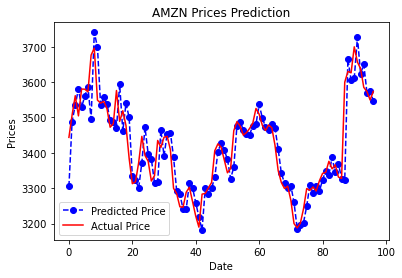

In [106]:
test_range = amzn_df[0:int(len(amzn_df)*.7)].index
plt.plot(test_range, model_predictions, color='blue', marker='o',
        linestyle ='dashed', label='Predicted Price')
plt.plot(test_range, test, color='red', label='Actual Price')
plt.title('AMZN Prices Prediction')
plt.xlabel('Date')
from pylab import rcParams
rcParams['figure.figsize'] = 36, 20
plt.ylabel('Prices')
plt.legend()
plt.show()

## The arima model is likely too slow to implement onto the dashboard, so I will build an xgboost model instead. I will make two general models, one that predicts next day close and one that predicts next 4 hour close.

In [107]:
prediction_df = build_xgboost_df('AMZN')
prediction_df.tail()

,Close_1day,Close_2day,Close_3day,High_1day,High_2day,High_3day,Cot_1day,Cot_2day,Cot_3day,Vol_1day,Vol_2day,Vol_3day,value,Date,News_Sentiment_1day
129,3230.11,3265.16,3259.05,3260.36,3295.73,3279.82,-0.00795,-0.00288,-0.00233,2344894.0,2364794.0,3132345.0,3223.07,2021-05-28,0.195417
130,3265.16,3259.05,3244.99,3295.73,3279.82,3257.95,-0.00288,-0.00233,0.00917,2364794.0,3132345.0,2304524.0,3230.11,2021-05-27,0.288600
131,3259.05,3244.99,3203.08,3279.82,3257.95,3256.30,-0.00233,0.00917,-0.01444,3132345.0,2304524.0,3838494.0,3265.16,2021-05-26,0.237599
132,3244.99,3203.08,3247.68,3257.95,3256.30,3259.68,0.00917,-0.01444,0.00101,2304524.0,3838494.0,2549587.0,3259.05,2021-05-25,0.132458
133,3203.08,3247.68,3231.80,3256.30,3259.68,3234.58,-0.01444,0.00101,0.01152,3838494.0,2549587.0,2588052.0,3244.99,2021-05-24,0.160100


In [108]:
test_data, train_data = prediction_df[0:int(len(prediction_df)*.07)], \
                            prediction_df[int(len(prediction_df)*.07):]

#### - Plot data in the following format:
- 3 distinct lines separated by color
- plot y_train
- plot y_test
- plot y_preds

In [109]:
X_test = test_data.drop(columns = ['Date', 'value'])
#X_test_scaled = pd.DataFrame(sc.transform(X_test), columns = X_test.columns)
y_train = train_data.value
X_train = train_data.drop(columns = ['Date', 'value'])

y_test = test_data.value

In [110]:
xg = GradientBoostingRegressor()
xg.fit(X_train, y_train)
y_pred = pd.Series(xg.predict(X_test))

In [111]:
xgboost_prediction_df = pd.DataFrame(columns = ['value', 'data_category', 'Date'])
combined_list = pd.concat([y_test, y_train, y_pred])
combined_list.reset_index(drop = True, inplace = True)

xgboost_prediction_df.value = combined_list
xgboost_prediction_df.Date = prediction_df.Date



test_cutoff = len(y_test)
pred_cutoff = len(y_test) + len(y_train)
counter = 0
for i in range(len(combined_list)):
    if (counter > test_cutoff)&(counter < pred_cutoff):
        xgboost_prediction_df.data_category[i] = 'train'
    elif (counter <= test_cutoff):
        xgboost_prediction_df.data_category[i] = 'test'
    elif (counter >= pred_cutoff):
        xgboost_prediction_df.data_category[i] = 'pred'
    counter += 1
        
pred_dates = xgboost_prediction_df.iloc[:len(y_test)].Date
count = 0
i = 0
for date in xgboost_prediction_df.Date:
    if str(date)[0] == 'N':
        xgboost_prediction_df.Date[count] = pred_dates[i]
        i += 1
    count += 1

In [112]:
xg_df, xg, pred_df, apple_mae = build_general_model_daily_prediction_df('AMZN')

In [113]:
float(mean_absolute_error(y_test, y_pred))

61.00935280360439

In [114]:
fig = px.line(xgboost_prediction_df, x='Date', y='value', color='data_category', markers=True)
fig.show()

In [115]:
tomorrow_tsla_close_price = make_tomorrow_pred('AMZN', prediction_df, xg)

In [116]:
tomorrow_tsla_close_price

array([3426.09990306])

In [117]:
tomorrow_tsla_close_price

array([3426.09990306])

In [118]:
a = vader_sentiment_analysis(apikey, 'AMZN', 20)
    
b = np.mean(trim_news_dates(datetime.today().strftime('%Y-%m-%d'), a).CompoundAvg)

In [119]:
trim_news_dates('2021-11-22' ,a)

,Date,Title,Text,CompoundScoreTitle,PositiveScoreTitle,NegativeScoreTitle,CompoundScoreText,NeutralScoreTitle,NeutralScoreText,textLeans,titleLeans,PositiveScoreText,NegativeScoreText,CompoundAvg,Symbol,weekday,time


In [120]:
b

0.2261928571428571

#### Feature Importances

In [121]:
xg_df, xg, pred_df, mae = build_general_model_daily_prediction_df('AAPL')

In [122]:
importance_df = pd.DataFrame(xg.feature_importances_, columns=['importance'])
importance_df['feature_name'] = prediction_df.drop(columns=['Date', 'value']).columns

In [123]:
importance_df.sort_values('importance', ascending=False, ignore_index=True)

,importance,feature_name
0,0.471958,Close_1day
1,0.210632,High_3day
2,0.161099,High_2day
3,0.065579,Close_3day
4,0.058491,High_1day
5,0.013097,Close_2day
6,0.004318,Cot_3day
7,0.003652,Vol_3day
8,0.003059,Cot_1day
9,0.003014,Vol_2day


<AxesSubplot:>

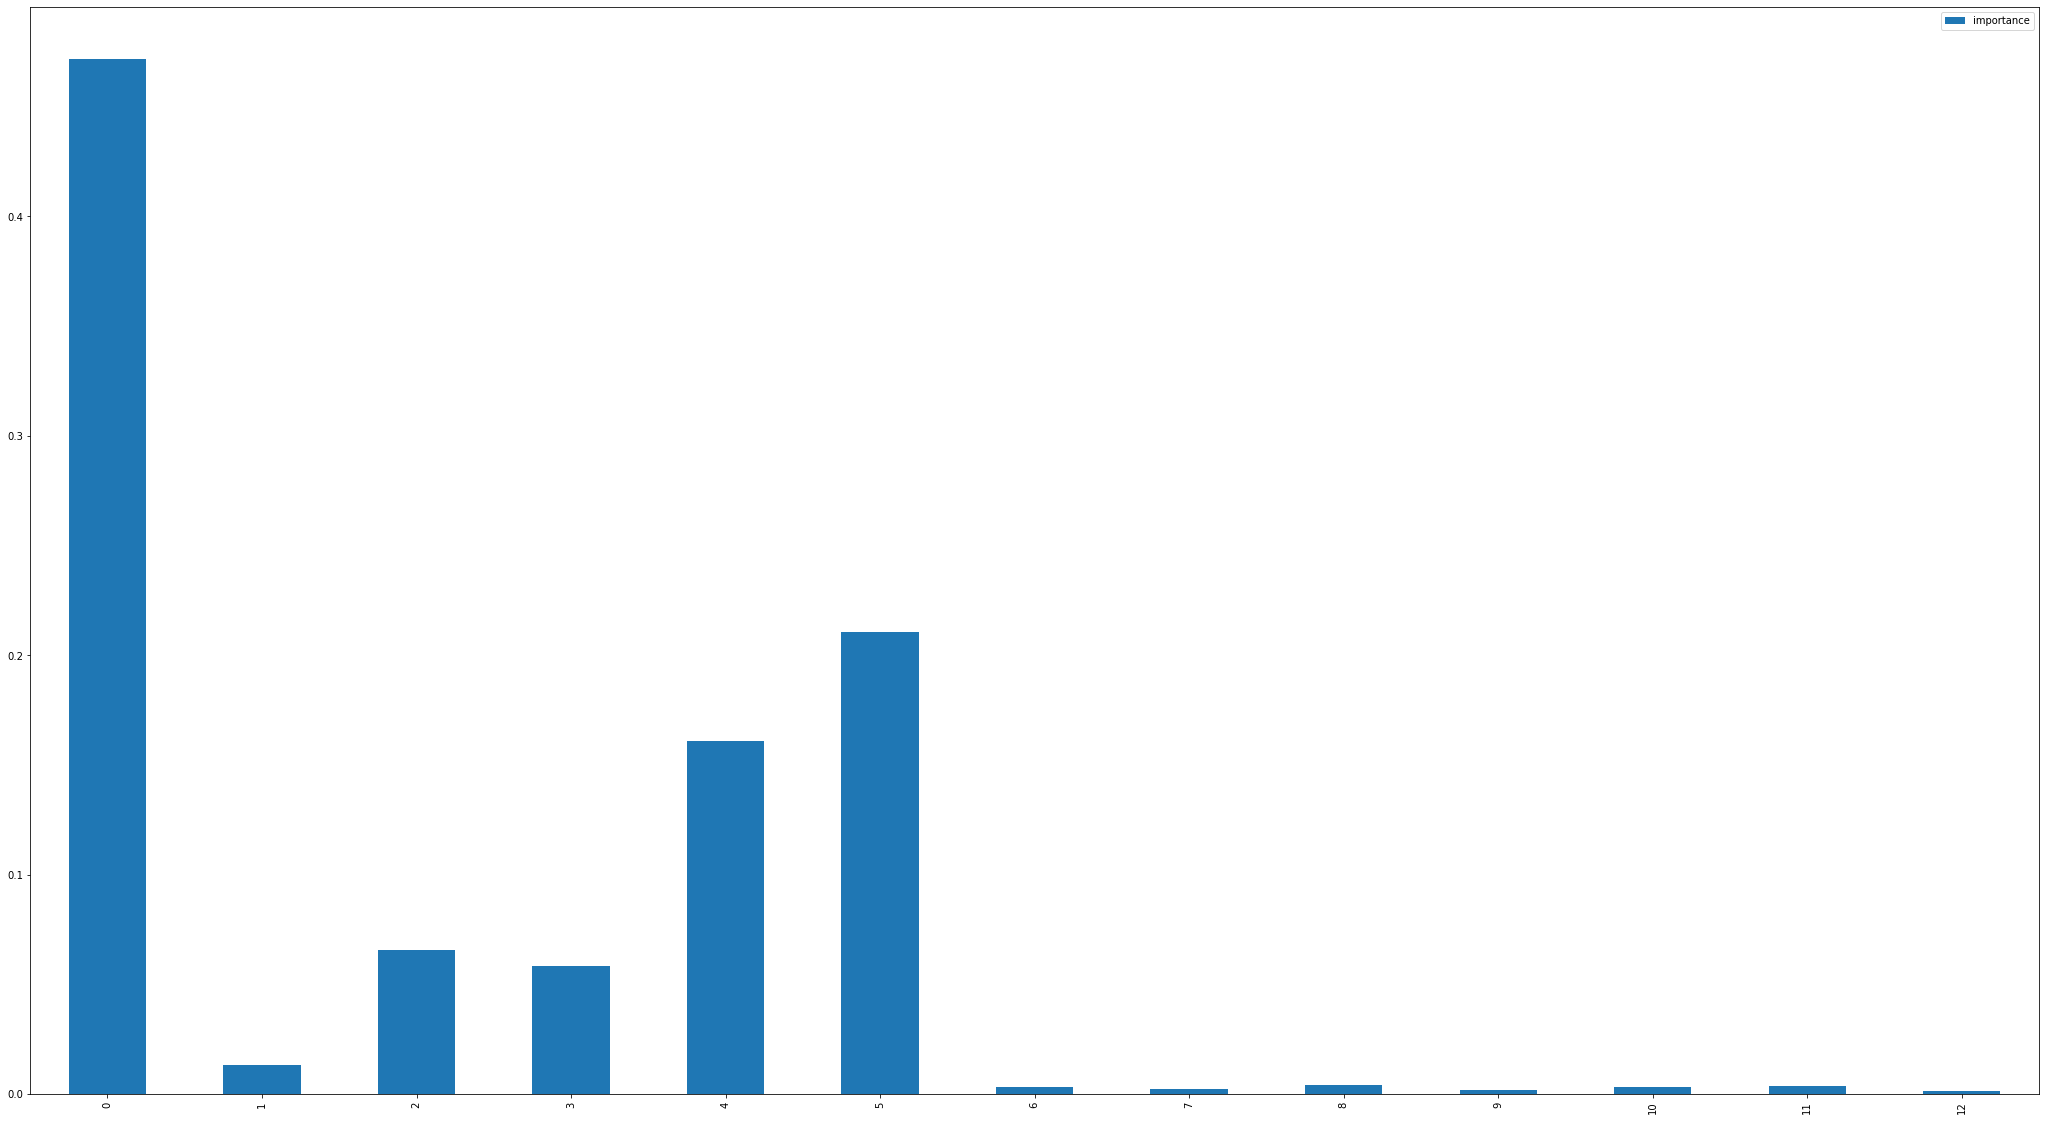

In [124]:
importance_df.plot(kind='bar')

In [125]:
fig = px.line(xg_df, x='Date', y='value', color='data_category', markers=True,
             title = 'NEXT Day Prediction: '+str(make_tomorrow_pred('MSFT', prediction_df, xg)) \
                                                +" +/- "+str(mae))
fig.show()

#### Unsurprisingly, the closing price of the previous day is the biggest predictor. Going forward, I am going to investigate how much public news sentiment can help this model.

In [126]:
df = vader_sentiment_analysis(apikey, 'MSFT')

In [127]:
df.head(3)

,Date,Title,Text,CompoundScoreTitle,PositiveScoreTitle,NegativeScoreTitle,CompoundScoreText,NeutralScoreTitle,NeutralScoreText,textLeans,titleLeans,PositiveScoreText,NegativeScoreText,CompoundAvg,Symbol,weekday,time
0,2021-12-02 07:35:00,Microsoft's CEO Just Sold $285 Million in Stoc...,Microsoft stock is near all-time highs and its...,-0.5106,0.000,0.248,0.4285,0.752,0.746,Positive,Negative,0.186,0.068,-0.04105,MSFT,3,07:35:00
1,2021-12-01 19:07:12,Microsoft (MSFT) Stock Moves -0.15%: What You ...,Microsoft (MSFT) closed at $330.08 in the late...,0.0000,0.000,0.000,0.0000,1.000,1.000,Neutral,Neutral,0.000,0.000,0.00000,MSFT,2,19:07:12
2,2021-12-01 16:08:31,Microsoft's standalone ‘Teams Essentials' serv...,Microsoft launched a new standalone version of...,0.0772,0.106,0.000,0.1280,0.894,0.955,Positive,Positive,0.045,0.000,0.10260,MSFT,2,16:08:31


#### Now, I need to implement sentiment scores into already developed time series dataframe that I have developed. Each day should receive a general sentiment. What I will do is if add three columns one_day news sentiment, two_day news sentiment, and three_day news sentiment. These columns will contain the compund average score of all the compound average scores of the news titles/artiles for the day.

In [128]:
trimmed_df = trim_news_dates('2021-11-22', df)

In [129]:
np.mean(trimmed_df.CompoundAvg)

0.401975

#### The Plan:
- Add a clause into the build build_general_model_daily_prediction_df(stock) that will add the mean Compound AvG score for the prior stock day.

In [130]:
prediction_df = build_xgboost_df('AAPL')


In [131]:
prediction_df['News_Sentiment_1day'] = None

In [132]:
df = vader_sentiment_analysis(apikey, 'AAPL')

In [133]:
determine_date_range(df)

(Timestamp('2020-10-25 06:15:20'), Timestamp('2021-12-02 10:59:10'))

In [134]:
prediction_df.News_Sentiment_1day = prediction_df.Date.apply(
    lambda dat: np.mean(trim_news_dates(str(dat), df).CompoundAvg))

In [135]:
prediction_df.tail()

,Close_1day,Close_2day,Close_3day,High_1day,High_2day,High_3day,Cot_1day,Cot_2day,Cot_3day,Vol_1day,Vol_2day,Vol_3day,value,Date,News_Sentiment_1day
129,125.279999,126.849998,126.900002,127.639999,127.389999,128.320007,-0.00917,-0.00087,-0.00720,94625600.0,56575900.0,72009500.0,124.610001,2021-05-28,0.085120
130,126.849998,126.900002,127.099998,127.389999,128.320007,127.940002,-0.00087,-0.00720,0.00865,56575900.0,72009500.0,63092900.0,125.279999,2021-05-27,0.388271
131,126.900002,127.099998,125.430000,128.320007,127.940002,128.000000,-0.00720,0.00865,-0.01870,72009500.0,63092900.0,79295400.0,126.849998,2021-05-26,0.170662
132,127.099998,125.430000,127.309998,127.940002,128.000000,127.720001,0.00865,-0.01870,0.01661,63092900.0,79295400.0,76857100.0,126.900002,2021-05-25,0.068586
133,125.430000,127.309998,124.690002,128.000000,127.720001,124.919998,-0.01870,0.01661,0.01242,79295400.0,76857100.0,92612000.0,127.099998,2021-05-24,-0.120000


#### Now, I can make additional predictions.

In [136]:
test_data, train_data = prediction_df[0:int(len(prediction_df)*.1)], \
                        prediction_df[int(len(prediction_df)*.1):]

X_test = test_data.drop(columns = ['Date', 'value'])

y_train = train_data.value
X_train = train_data.drop(columns = ['Date', 'value'])
y_test = test_data.value

xg = GradientBoostingRegressor()
xg.fit(X_train, y_train)
y_pred = pd.Series(xg.predict(X_test))
mae = np.sqrt(mean_squared_error(y_test, y_pred))

xgboost_prediction_df = pd.DataFrame(columns = ['value', 'data_category', 'Date'])
combined_list = pd.concat([y_test, y_train, y_pred])
combined_list.reset_index(drop = True, inplace = True)

xgboost_prediction_df.value = combined_list
xgboost_prediction_df.Date = prediction_df.Date



test_cutoff = len(y_test)
pred_cutoff = len(y_test) + len(y_train)
counter = 0
for i in range(len(combined_list)):
    if (counter > test_cutoff)&(counter < pred_cutoff):
        xgboost_prediction_df.data_category[i] = 'train'
    elif (counter <= test_cutoff):
        xgboost_prediction_df.data_category[i] = 'test'
    elif (counter >= pred_cutoff):
        xgboost_prediction_df.data_category[i] = 'pred'
    counter += 1

pred_dates = xgboost_prediction_df.iloc[:len(y_test)].Date
count = 0
i = 0
for date in xgboost_prediction_df.Date:
    if str(date)[0] == 'N':
        xgboost_prediction_df.Date[count] = pred_dates[i]
        i += 1
        count += 1

In [137]:
count = 0
i = 0
for date in xgboost_prediction_df.Date:
    if str(date)[0] == 'N':
        xgboost_prediction_df.Date[count] = pred_dates[i]
        i += 1
    count += 1

In [138]:
xgboost_prediction_df

,value,data_category,Date
0,164.770000,test,2021-12-01
1,165.300000,test,2021-11-30
2,160.240000,test,2021-11-29
3,156.810000,test,2021-11-26
4,161.940000,test,2021-11-24
...,...,...,...
142,152.215187,pred,2021-11-18
143,150.414141,pred,2021-11-17
144,151.547776,pred,2021-11-16
145,151.387078,pred,2021-11-15


In [139]:
fig = px.line(xgboost_prediction_df, x='Date', y='value', color='data_category', markers=True,
             title = 'NEXT Day Prediction: '+str(make_tomorrow_pred('AAPL', prediction_df, xg)) \
                                                +" +/- "+str(mae))
fig.show()

In [140]:
mae

7.174533649836037

In [141]:
apple_mae

64.77010502959239

#### Now, that I have added news sentiment I will compare models and explore results. I want to investigate if the news sentiment is helping the model.

In [142]:
xg_df, xg, pred_df, mae = build_general_model_daily_prediction_df('AAPL')

In [143]:
mae

7.266569020127268

In [144]:
fig = px.line(xg_df, x='Date', y='value', color='data_category', markers=True,
             title = 'WITH NEWS SENTIMENT NEXT Day Prediction For AAPL: '+str(make_tomorrow_pred('ACB', pred_df, xg)) \
                                                +" +/- "+str(mae))
fig.show()

In [145]:
fig = px.line(xg_df, x='Date', y='value', color='data_category', markers=True,
             title = 'WITHOUT NEWS SENTIMENT NEXT Day Prediction For AAPL: '+str(make_tomorrow_pred('AAPL', pred_df, xg)) \
                                                +" +/- "+str(mae))
fig.show()

In [146]:
amzn_df = build_time_series_df('AAPL')
test_data, train_data = amzn_df[0:int(len(amzn_df)*.7)], \
                            amzn_df[int(len(amzn_df)*.7):]

train = train_data['Close'].values
test = test_data['Close'].values
# Create list of x train valuess
history = [x for x in train]
# establish list for predictions
model_predictions = []
# Count number of test data points
N_test_observations = len(test)
# loop through every data point
for time_point in range(N_test_observations):
    model = ARIMA(history, order=(5,1,1))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    model_predictions.append(yhat)
    true_test_value = test[time_point]
    history.append(true_test_value)
MAE_error = mean_absolute_error(test, model_predictions).numpy()
print('Testing Mean Absolute Error is {}'.format(MAE_error))


Testing Mean Absolute Error is 2.260234182001598


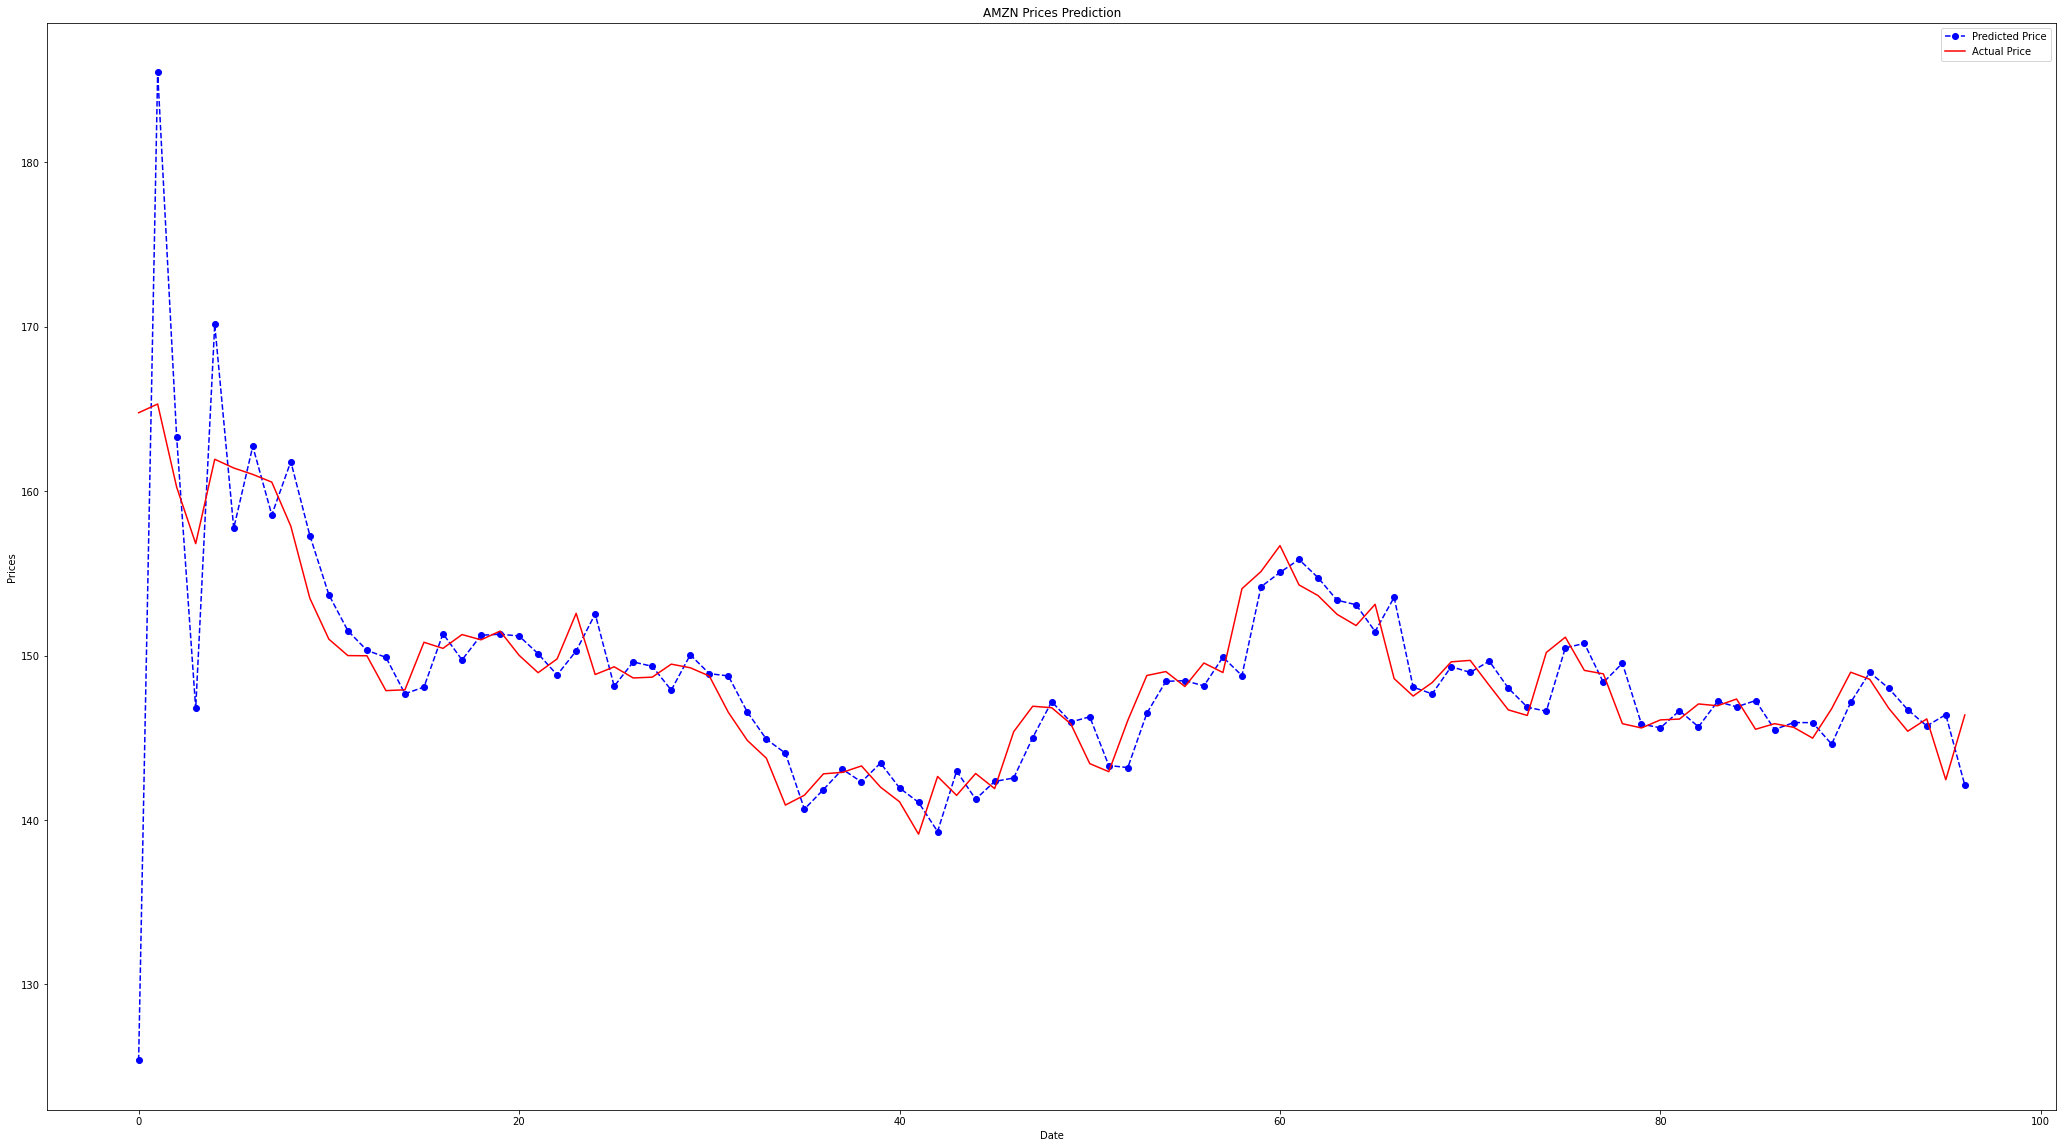

In [147]:
test_range = amzn_df[0:int(len(amzn_df)*.7)].index
plt.plot(test_range, model_predictions, color='blue', marker='o',
        linestyle ='dashed', label='Predicted Price')
plt.plot(test_range, test, color='red', label='Actual Price')
plt.title('AMZN Prices Prediction')
plt.xlabel('Date')
from pylab import rcParams
rcParams['figure.figsize'] = 36, 20
plt.ylabel('Prices')
plt.legend()
plt.show()

#### Now, I will develop an XGBOOST model the same way except this time it will predict the next close price in a 1 hour window.

In [148]:
hourly_stock = fmpsdk.historical_chart(apikey, 'AAPL', "1hour")

In [149]:
hourly_stock[0]['date']

'2021-12-02 11:00:00'

In [150]:
hourly_df = pd.DataFrame(columns = ['Time', 'Close', 'High', 'Volume', 'Low'])
opens = []
times = []
closes = []
highs = []
volumes = []
lows = []
for hour in hourly_stock:
    times.append(hour['date'])
    opens.append(hour['open'])
    closes.append(hour['close'])
    highs.append(hour['high'])
    volumes.append(hour['volume'])
    lows.append(hour['low'])

hourly_df.Time = times
hourly_df.Close = closes
hourly_df.High = highs
hourly_df.Volume = volumes
hourly_df.Low = lows

In [151]:
hourly_df.head()

,Time,Close,High,Volume,Low
0,2021-12-02 11:00:00,161.7800,162.1300,16000725,160.21
1,2021-12-02 10:00:00,160.4901,161.3700,21910226,159.03
2,2021-12-01 16:00:00,164.6000,165.2800,4200867,164.02
3,2021-12-01 15:00:00,164.6700,167.4488,27461028,164.53
4,2021-12-01 14:00:00,167.1800,168.3900,13097758,167.01


#### Now, I just need to remake the xg_df

In [152]:
pred_hourly_df = build_xgboost_hourly_df('AAPL')

In [153]:
pred_hourly_df.head(1)

,Close_1hour,Close_2hour,Close_3hour,High_1hour,High_2hour,High_3hour,Low_1hour,Low_2hour,Low_3hour,Vol_1hour,Vol_2hour,Vol_3hour,value,Time
0,160.4901,164.6,164.67,161.37,165.28,167.4488,159.03,164.02,164.53,21910226,4200867,27461028,161.78,2021-12-02 11:00:00


#### Now, I can make prediction and evaluate the model

In [154]:
xg_hourly_df, xg_hourly_model, prediction_hourly_df, hourly_mae = build_general_model_hourly_prediction_df('AAPL')

In [155]:
prediction_hourly_df

,Close_1hour,Close_2hour,Close_3hour,High_1hour,High_2hour,High_3hour,Low_1hour,Low_2hour,Low_3hour,Vol_1hour,Vol_2hour,Vol_3hour,value,Time
0,160.4901,164.6000,164.6700,161.3700,165.2800,167.4488,159.030,164.02,164.5300,21910226,4200867,27461028,161.7800,2021-12-02 11:00:00
1,164.6000,164.6700,167.1800,165.2800,167.4488,168.3900,164.020,164.53,167.0100,4200867,27461028,13097758,160.4901,2021-12-02 10:00:00
2,164.6700,167.1800,168.3836,167.4488,168.3900,169.6700,164.530,167.01,167.3800,27461028,13097758,17329525,164.6000,2021-12-01 16:00:00
3,167.1800,168.3836,169.1200,168.3900,169.6700,170.3000,167.010,167.38,169.0600,13097758,17329525,14039583,164.6700,2021-12-01 15:00:00
4,168.3836,169.1200,169.2613,169.6700,170.3000,170.2000,167.380,169.06,169.0799,17329525,14039583,21409097,167.1800,2021-12-01 14:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
270,144.1200,144.0000,142.1400,144.1500,144.2150,142.1700,143.545,143.78,141.8600,6852688,11379848,2039976,144.0450,2021-10-07 12:00:00
271,144.0000,142.1400,141.9700,144.2150,142.1700,142.1500,143.780,141.86,141.0900,11379848,2039976,11000633,144.1200,2021-10-07 11:00:00
272,142.1400,141.9700,141.1650,142.1700,142.1500,141.6600,141.860,141.09,140.7200,2039976,11000633,7997851,144.0000,2021-10-07 10:00:00
273,141.9700,141.1650,140.9111,142.1500,141.6600,140.9200,141.090,140.72,139.5600,11000633,7997851,9085450,142.1400,2021-10-06 16:00:00


In [156]:
xg_hourly_df

,value,data_category,Time
0,161.780000,test,2021-12-02 11:00:00
1,160.490100,test,2021-12-02 10:00:00
2,164.600000,test,2021-12-01 16:00:00
3,164.670000,test,2021-12-01 15:00:00
4,167.180000,test,2021-12-01 14:00:00
...,...,...,...
276,164.501354,pred,2021-12-02 10:00:00
277,167.797279,pred,2021-12-01 16:00:00
278,168.722589,pred,2021-12-01 15:00:00
279,168.814312,pred,2021-12-01 14:00:00


In [157]:
fig = px.line(xg_hourly_df, x='Time', y='value', color='data_category', markers=True
             )
fig.show()

#### Lastly, I need to predict the next hour close price.

In [158]:
hourly_stock = fmpsdk.historical_chart(apikey, 'AAPL', "1hour")

In [159]:
hourly_stock[0]

{'date': '2021-12-02 11:00:00',
 'open': 160.49,
 'low': 160.21,
 'high': 162.13,
 'close': 161.78,
 'volume': 16000725}

In [160]:
apple_next_hour_price = make_next_hour_pred('AAPL', prediction_hourly_df, xg_hourly_model)

In [161]:
apple_next_hour_price

array([162.3208971])

In [162]:
fig = px.line(xg_hourly_df, x='Time', y='value', color='data_category', markers=True,
              title = 'Hourly Prediction For AAPL, Next Hour Prediction: '+ \
              str(make_next_hour_pred('AAPL', prediction_hourly_df, xg_hourly_model)) + '+/- '+str(mae)
             )
fig.show()

## Optimization
 - Up to this point the XGBOOST models are vanilla. I suspect optimization will not be useful because of the computation added to an already strained system.
 - However, I want to see how much improvement I can get for both the daily and general models.
 - To test this I will make two vanilla models predicting AMZN and then two optimized models predicting AMZN.

### Hourly Vanilla

In [163]:
xg_hourly_df, xg_hourly_model, prediction_hourly_df, hourly_mae = build_general_model_hourly_prediction_df('AMZN')
fig = px.line(xg_hourly_df, x='Time', y='value', color='data_category', markers=True,
              title = 'Hourly Prediction For AMZN, Next Hour Prediction: '+ \
              str(make_next_hour_pred('AMZN', prediction_hourly_df, xg_hourly_model)) + '+/- '+str(mae)
             )
fig.show()

### Daily Vanilla

In [164]:
xg_df, xg, pred_df, mae = build_general_model_daily_prediction_df('AMZN')
fig = px.line(xg_df, x='Date', y='value', color='data_category', markers=True,
              title = 'Daily Prediction For AMZN, Next Day Close Prediction: '+ \
              str(make_tomorrow_pred('AMZN', pred_df, xg)) + '+/- '+str(mae)
             )
fig.show()


### Hourly Optimized

In [165]:
prediction_df = build_xgboost_hourly_df('AMZN')

test_data, train_data = prediction_df[0:int(len(prediction_df)*.025)], \
                        prediction_df[int(len(prediction_df)*.025):]

X_test = test_data.drop(columns = ['Time', 'value'])

y_train = train_data.value
X_train = train_data.drop(columns = ['Time', 'value'])
y_test = test_data.value

parameters = {
    'max_depth': range (0, 15, 1),
    'n_estimators': range (1, 10, 1),
    'learning_rate':  np.linspace(.1, 1, 10)   
}



xg = GradientBoostingRegressor()

grid_search = GridSearchCV(
    estimator=xg,
    param_grid=parameters,
    scoring = 'neg_root_mean_squared_error',
    n_jobs = 3,
    cv = 3,
    verbose=True
)

grid_search.fit(X_train, y_train)
print(grid_search.best_params_)
xg = GradientBoostingRegressor(**grid_search.best_params_)
xg.fit(X_train, y_train)
#xg.fit(X_train, y_train)
y_pred = pd.Series(xg.predict(X_test))
mae = np.sqrt(mean_squared_error(y_test, y_pred))

xgboost_prediction_df = pd.DataFrame(columns = ['value', 'data_category', 'Time'])
combined_list = pd.concat([y_test, y_train, y_pred])
combined_list.reset_index(drop = True, inplace = True)

xgboost_prediction_df.value = combined_list
xgboost_prediction_df.Time = prediction_df.Time



test_cutoff = len(y_test)
pred_cutoff = len(y_test) + len(y_train)
counter = 0
for i in range(len(combined_list)):
    if (counter > test_cutoff)&(counter < pred_cutoff):
        xgboost_prediction_df.data_category[i] = 'train'
    elif (counter <= test_cutoff):
        xgboost_prediction_df.data_category[i] = 'test'
    elif (counter >= pred_cutoff):
        xgboost_prediction_df.data_category[i] = 'pred'
    counter += 1

pred_dates = list(xgboost_prediction_df.iloc[:len(y_test)].Time)
count = 0
i = 0
for date in xgboost_prediction_df.Time:
    if date is np.nan:
        xgboost_prediction_df.Time[count] = pred_dates[i]
        i += 1
    count += 1

Fitting 3 folds for each of 1350 candidates, totalling 4050 fits
{'learning_rate': 1.0, 'max_depth': 4, 'n_estimators': 1}


In [166]:
fig = px.line(xgboost_prediction_df, x='Time', y='value', color='data_category', markers=True,
              title = 'Hourly Prediction For AMZN, Next Hour Prediction: '+ \
              str(make_next_hour_pred('AMZN', prediction_df, xg)) + '+/- '+str(mae)
             )
fig.show()

### Daily Optimized

In [167]:
prediction_df = build_xgboost_df('AMZN')

test_data, train_data = prediction_df[0:int(len(prediction_df)*.1)], \
                        prediction_df[int(len(prediction_df)*.1):]

X_test = test_data.drop(columns = ['Date', 'value'])

y_train = train_data.value
X_train = train_data.drop(columns = ['Date', 'value'])
y_test = test_data.value

parameters = {
    'max_depth': range (0, 15, 1),
    'n_estimators': range (1, 10, 1),
    'learning_rate':  np.linspace(.1, 1, 10)   
}



xg = GradientBoostingRegressor()

grid_search = GridSearchCV(
    estimator=xg,
    param_grid=parameters,
    scoring = 'neg_root_mean_squared_error',
    n_jobs = 3,
    cv = 3,
    verbose=True
)

grid_search.fit(X_train, y_train)
print(grid_search.best_params_)
xg = GradientBoostingRegressor(**grid_search.best_params_)
xg.fit(X_train, y_train)

y_pred = pd.Series(xg.predict(X_test))
mae = np.sqrt(mean_squared_error(y_test, y_pred))

xgboost_prediction_df = pd.DataFrame(columns = ['value', 'data_category', 'Date'])
combined_list = pd.concat([y_test, y_train, y_pred])
combined_list.reset_index(drop = True, inplace = True)

xgboost_prediction_df.value = combined_list
xgboost_prediction_df.Date = prediction_df.Date



test_cutoff = len(y_test)
pred_cutoff = len(y_test) + len(y_train)
counter = 0
for i in range(len(combined_list)):
    if (counter > test_cutoff)&(counter < pred_cutoff):
        xgboost_prediction_df.data_category[i] = 'train'
    elif (counter <= test_cutoff):
        xgboost_prediction_df.data_category[i] = 'test'
    elif (counter >= pred_cutoff):
        xgboost_prediction_df.data_category[i] = 'pred'
    counter += 1

pred_dates = xgboost_prediction_df.iloc[:len(y_test)].Date
count = 0
i = 0
for date in xgboost_prediction_df.Date:
    if str(date)[0] == 'N':
        xgboost_prediction_df.Date[count] = pred_dates[i]
        i += 1
    count += 1


#return xgboost_prediction_df, xg, prediction_df, mae

Fitting 3 folds for each of 1350 candidates, totalling 4050 fits
{'learning_rate': 0.30000000000000004, 'max_depth': 2, 'n_estimators': 9}


In [168]:
fig = px.line(xgboost_prediction_df, x='Date', y='value', color='data_category', markers=True,
              title = 'Daily Prediction For AMZN, Next Day Close Prediction: '+ \
              str(make_tomorrow_pred('AMZN', prediction_df, xg)) + '+/- '+str(mae)
             )
fig.show()

### Optimization Analysis
- Vanilla Daily
    - MAE = 76.8
- Vanilla Hourly
    - MAE = .6
- Optimized Daily
    - MAE = 71.5
- Optimized Hourly
    - MAE = 38.7
    
    
#### Based on these results I am concluding that is acceptable to leave the implemented algorithms in their vanilla state.

## Volume, Insider Trading, and Price Inspection

#### Because stock price is determined by supply and demand, I am curious to see how much large sell offs affect the price. To investigate this I am going to look at insider trades, share volume and stock price. 
- First, I will see how volume and price look together

In [169]:
amzn_stock_data = fmpsdk.historical_price_full(apikey, 'AMZN')

In [170]:
prices = []
volumes = []
dates = []
for json in amzn_stock_data['historical']:
    prices.append(json['open'])
    volumes.append(json['volume'])
    dates.append(json['date']) 

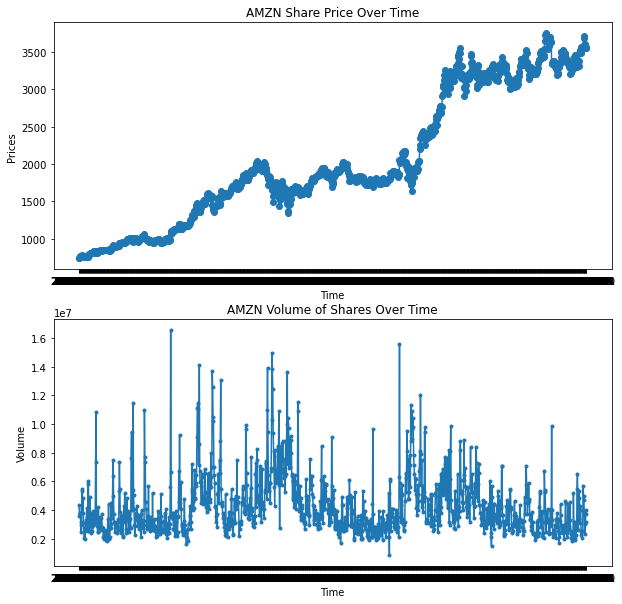

In [171]:
dates.reverse()
prices.reverse()
volumes.reverse()
x1 = dates
y1 = prices

x2 = dates
y2 = volumes


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,10))

ax1.set_title('AMZN Share Price Over Time')
ax1.plot(x1, y1, 'o-')
ax1.set_ylabel('Prices')
ax1.set_xlabel('Time')

ax2.set_title('AMZN Volume of Shares Over Time')
ax2.plot(x2, y2, '.-')
ax2.set_xlabel('Time')
ax2.set_ylabel('Volume')

plt.show()



In [172]:
from scipy.stats import pearsonr

In [173]:
correlation, p_value = pearsonr(prices, volumes)
print('Correlation:', '        Correlation P-Value:')
print(correlation, p_value)

Correlation:         Correlation P-Value:
-0.0459035228486641 0.1036608598960429


#### There does appear to be a relationship between the two. The other consideration to make is stock splits, which is when a company splits their current stock amount to make more. The negative correlation adn pval above .05 threshold confirm there is a relationship. This would increase volume but not necessarily affect price. Now, I will see how insider trades might affect these two.

In [174]:
amzn_inside_trade = fmpsdk.insider_trading(apikey, 'AMZN', limit = 1000)

In [175]:
shares_sold = []
date = []

for json in amzn_inside_trade:
    if json['transactionType'] == 'S-Sale':
        shares_sold.append(json['securitiesTransacted'])
        date.append(json['transactionDate'])

shares_sold.reverse()
date.reverse()

In [176]:
idx = 0
for date_ in date:
    date[idx] = date_[5:]
    idx += 1

Text(0.5, 0, 'Date')

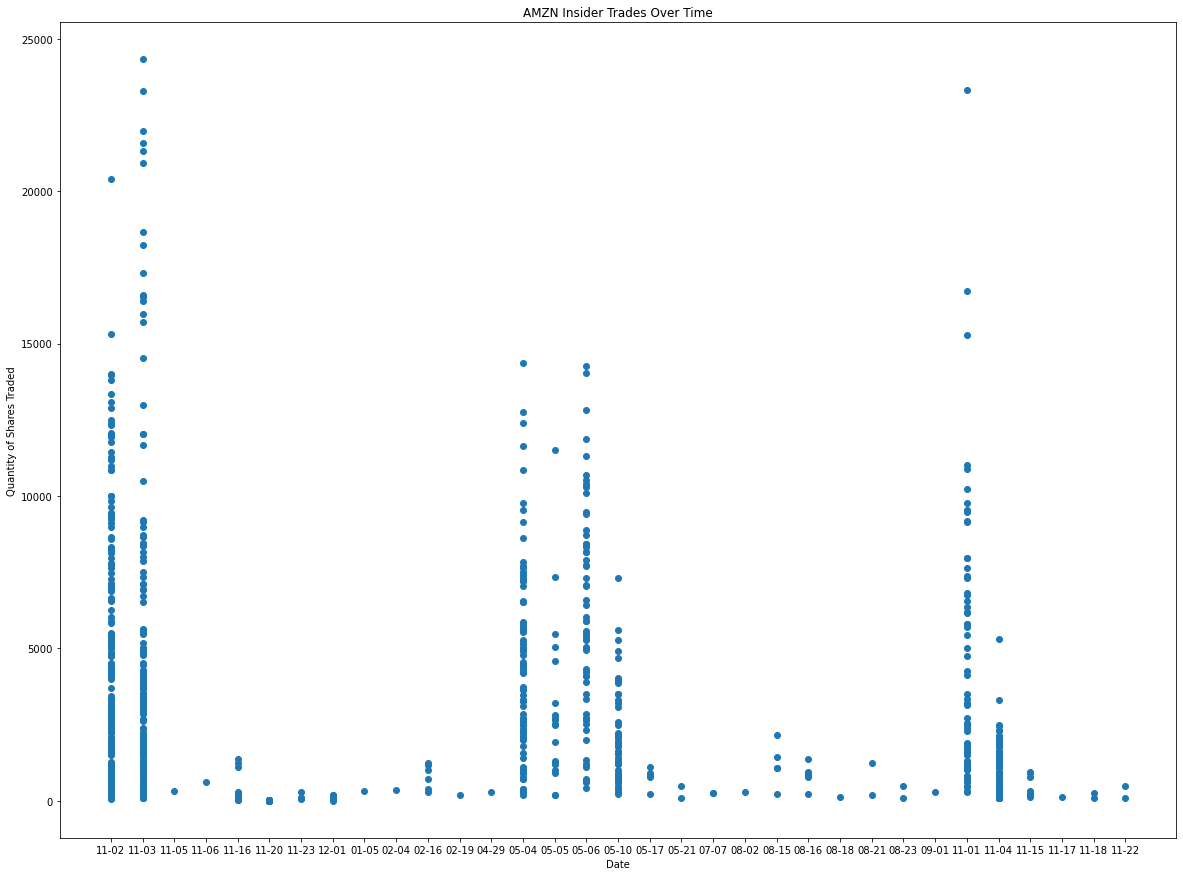

In [177]:
x1 = date
y1 = shares_sold




fig, ax1 = plt.subplots(1, 1, figsize=(20,15))

ax1.set_title('AMZN Insider Trades Over Time')
ax1.scatter(x1, y1)
#ax1.boxplot(x1, y1)
ax1.set_ylabel('Quantity of Shares Traded')
ax1.set_xlabel('Date')

#### There are clearly moments when the insider trading activity is high. This is very, very interesting. In order to see if this affects price/volume I need to join the data based on date. I will do this in a pandas dataframe where the index will be date and go day by day. Because the api call to get insider trades has the limit parameter, I will define the scope of the date from that date range.

In [178]:
amzn_inside_trade = fmpsdk.insider_trading(apikey, 'AMZN', limit = 750)

In [179]:
insider_df = pd.DataFrame(columns = ['SharesTransacted', 'Date', 'Volume', 'Open_Price'])

shares_sold = []
date = []

for json in amzn_inside_trade:
    if json['transactionType'] == 'S-Sale':
        shares_sold.append(json['securitiesTransacted'])
        date.append(json['transactionDate'])
insider_df.Date = date
insider_df.SharesTransacted = shares_sold

In [180]:
insider_df.head()

,SharesTransacted,Date,Volume,Open_Price
0,492.0,2021-11-22,NaN,NaN
1,105.0,2021-11-22,NaN,NaN
2,86.0,2021-11-18,NaN,NaN
3,271.0,2021-11-18,NaN,NaN
4,139.0,2021-11-17,NaN,NaN


#### There are multiple shares transacted in a single day. I need to add these values so that there is just one day per row.

In [181]:
insider_df.SharesTransacted = insider_df.Date.apply(lambda date:
                                np.sum(insider_df.loc[insider_df.Date == date].SharesTransacted))

#### Now, I need to drop duplicate dates

In [182]:
insider_df.Date.value_counts()

2021-11-04    92
2021-11-03    84
2021-05-04    80
2021-11-01    62
2021-05-06    61
2021-05-10    57
2021-11-02    44
2020-11-20    30
2020-12-01    19
2021-05-05    19
2020-11-16    13
2021-11-15    11
2021-02-16     6
2020-11-23     6
2021-08-16     6
2021-05-17     5
2021-08-15     5
2021-11-22     2
2021-05-21     2
2021-11-18     2
2021-08-21     2
2021-08-23     2
2021-07-07     2
2021-08-02     1
2021-08-18     1
2021-04-29     1
2021-02-19     1
2021-02-04     1
2021-01-05     1
2021-09-01     1
2021-11-16     1
2021-11-17     1
Name: Date, dtype: int64

In [183]:
insider_df.drop_duplicates(inplace=True)

In [184]:
insider_df.reset_index(drop=True, inplace=True)

In [185]:
insider_df.head(5)

,SharesTransacted,Date,Volume,Open_Price
0,597.0,2021-11-22,NaN,NaN
1,357.0,2021-11-18,NaN,NaN
2,139.0,2021-11-17,NaN,NaN
3,34.0,2021-11-16,NaN,NaN
4,4431.0,2021-11-15,NaN,NaN


#### Now I need to fill in the missing dates

In [186]:
insider_df.Date = insider_df.Date.apply(lambda date: pd.to_datetime(date))
current_dates = list(insider_df.Date)

In [187]:
insider_df.Date.min()

Timestamp('2020-11-16 00:00:00')

In [188]:
insider_df.Date.max()

Timestamp('2021-11-22 00:00:00')

In [189]:
r = pd.date_range(start=insider_df.Date.min(), end=insider_df.Date.max())

In [190]:
insider_final_df = pd.DataFrame(columns = ['Date', 'Shares_Sold', 'Volume', 'Price'])

In [191]:
insider_final_df['Date'] = r

In [192]:
insider_final_df.Date = insider_final_df.Date.apply(lambda date: pd.to_datetime(date))

In [193]:
insider_final_df.Shares_Sold = insider_final_df.Date.apply(lambda date:
                                int(insider_df.loc[insider_df.Date == date].SharesTransacted)
                                if date in current_dates
                                else(0))

In [194]:
insider_final_df.head()

,Date,Shares_Sold,Volume,Price
0,2020-11-16,5207,NaN,NaN
1,2020-11-17,0,NaN,NaN
2,2020-11-18,0,NaN,NaN
3,2020-11-19,0,NaN,NaN
4,2020-11-20,172,NaN,NaN


#### Now, I need to add volume and price

In [195]:
from_ = insider_final_df.Date.min()
to_ = insider_final_df.Date.max()
amzn_stock_data = fmpsdk.historical_price_full(apikey, 'AMZN',from_date = from_,
                                              to_date = to_)

In [196]:
prices = []
volumes = []
dates = []
vol_price_df = pd.DataFrame(columns = ['price', 'date', 'volume'])
for json in amzn_stock_data['historical']:
    prices.append(json['open'])
    volumes.append(json['volume'])
    dates.append(json['date']) 
vol_price_df.price = prices
vol_price_df.date = dates
vol_price_df.volume = volumes

In [197]:
vol_price_df.head()

,price,date,volume
0,3676.3767,2021-11-22,4704715.0
1,3712.6900,2021-11-19,4946203.0
2,3566.3500,2021-11-18,5703538.0
3,3564.7200,2021-11-17,2560270.0
4,3539.0000,2021-11-16,2060478.0


In [198]:
type(vol_price_df.date[0])

str

In [199]:
vol_price_df.date = vol_price_df.date.apply(lambda date:pd.to_datetime(date))

In [200]:
stock_dates = list(vol_price_df.date)

In [201]:
insider_final_df.Volume = insider_final_df.Date.apply(lambda date:
                                int(vol_price_df.loc[vol_price_df.date == date].volume)
                                if date in stock_dates else(np.nan))
insider_final_df.Price = insider_final_df.Date.apply(lambda date:
                                int(vol_price_df.loc[vol_price_df.date == date].price)
                                if date in stock_dates else(np.nan))

In [202]:
insider_final_df.head(30)

,Date,Shares_Sold,Volume,Price
0,2020-11-16,5207,3808700.0,3093.0
1,2020-11-17,0,3444700.0,3183.0
2,2020-11-18,0,2916800.0,3134.0
3,2020-11-19,0,3010300.0,3105.0
4,2020-11-20,172,3374400.0,3117.0
5,2020-11-21,0,NaN,NaN
6,2020-11-22,0,NaN,NaN
7,2020-11-23,750,4708900.0,3116.0
8,2020-11-24,0,3602100.0,3100.0
9,2020-11-25,0,3790400.0,3141.0


In [203]:
insider_final_df.dropna(inplace=True)
insider_final_df.reset_index(drop=True, inplace=True)

In [204]:
insider_final_df

,Date,Shares_Sold,Volume,Price
0,2020-11-16,5207,3808700.0,3093.0
1,2020-11-17,0,3444700.0,3183.0
2,2020-11-18,0,2916800.0,3134.0
3,2020-11-19,0,3010300.0,3105.0
4,2020-11-20,172,3374400.0,3117.0
...,...,...,...,...
252,2021-11-16,34,2060478.0,3539.0
253,2021-11-17,139,2560270.0,3564.0
254,2021-11-18,357,5703538.0,3566.0
255,2021-11-19,0,4946203.0,3712.0


#### Now, I will compare them like I did above.

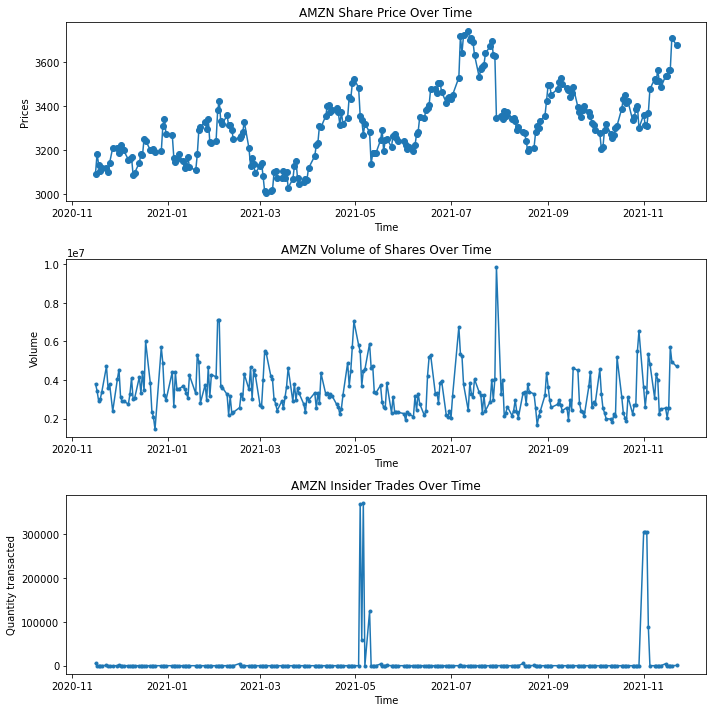

In [205]:
x = list(insider_final_df.Date)

y1 = list(insider_final_df.Price)

y2 = list(insider_final_df.Volume)

y3 = list(insider_final_df.Shares_Sold)




fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10,10))

ax1.set_title('AMZN Share Price Over Time')
ax1.plot(x, y1, 'o-')
ax1.set_ylabel('Prices')
ax1.set_xlabel('Time')

ax2.set_title('AMZN Volume of Shares Over Time')
ax2.plot(x, y2, '.-')
ax2.set_xlabel('Time')
ax2.set_ylabel('Volume')

ax3.set_title('AMZN Insider Trades Over Time')
ax3.plot(x, y3, '.-')
ax3.set_xlabel('Time')
ax3.set_ylabel('Quantity transacted')
plt.tight_layout()
plt.show()

#### Very, very, very interesting. It appears that in the 2021-05 time there was a large amount of shares sold that affected stock price. This could have been something else too. I am interested in the earnings report. By that, I mean I want to plot the 4 quarterly earnings because I think it's possible that some insiders knew the report was going to be less than expected earnings so they sold.

In [206]:
earnings_file_dates = fmpsdk.income_statement(apikey, 'AMZN', 'quarter')

In [207]:
dates = []
for report in earnings_file_dates:
    dates.append(report['fillingDate'])

In [208]:
dates = [pd.to_datetime(date) for date in dates]

In [209]:
relevant_dates = dates[:5]

In [210]:
relevant_dates[-1]

Timestamp('2020-10-30 00:00:00')

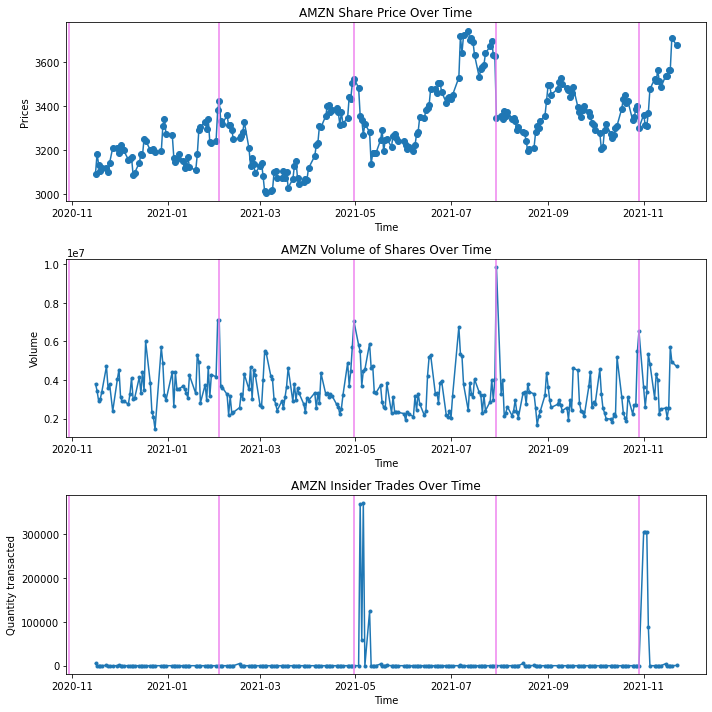

In [211]:
x = list(insider_final_df.Date)

y1 = list(insider_final_df.Price)

y2 = list(insider_final_df.Volume)

y3 = list(insider_final_df.Shares_Sold)




fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10,10))

ax1.set_title('AMZN Share Price Over Time')
ax1.plot(x, y1, 'o-')
ax1.set_ylabel('Prices')
ax1.set_xlabel('Time')

ax2.set_title('AMZN Volume of Shares Over Time')
ax2.plot(x, y2, '.-')
ax2.set_xlabel('Time')
ax2.set_ylabel('Volume')

ax3.set_title('AMZN Insider Trades Over Time')
ax3.plot(x, y3, '.-')
ax3.set_xlabel('Time')
ax3.set_ylabel('Quantity transacted')

ax1.axvline(relevant_dates[-1], color='violet')
ax1.axvline(relevant_dates[-2], color='violet')
ax1.axvline(relevant_dates[-3], color='violet')
ax1.axvline(relevant_dates[-4], color='violet')
ax1.axvline(relevant_dates[-5], color='violet')

ax2.axvline(relevant_dates[-1], color='violet')
ax2.axvline(relevant_dates[-2], color='violet')
ax2.axvline(relevant_dates[-3], color='violet')
ax2.axvline(relevant_dates[-4], color='violet')
ax2.axvline(relevant_dates[-5], color='violet')

ax3.axvline(relevant_dates[-1], color='violet')
ax3.axvline(relevant_dates[-2], color='violet')
ax3.axvline(relevant_dates[-3], color='violet')
ax3.axvline(relevant_dates[-4], color='violet')
ax3.axvline(relevant_dates[-5], color='violet')


plt.tight_layout()
plt.show()

#### Now, I will scale the process above so that I can view this table for any stock.

In [212]:
def insider_trade_analysis(symbol):
    inside_trade = fmpsdk.insider_trading(apikey, symbol, limit = 750)
    insider_df = pd.DataFrame(columns = ['SharesTransacted', 'Date', 'Volume', 'Open_Price'])

    shares_sold = []
    date = []

    for json in inside_trade:
        if json['transactionType'] == 'S-Sale':
            shares_sold.append(json['securitiesTransacted'])
            date.append(json['transactionDate'])
    insider_df.Date = date
    insider_df.SharesTransacted = shares_sold
    insider_df.SharesTransacted = insider_df.Date.apply(lambda date:
                                np.sum(insider_df.loc[insider_df.Date == date].SharesTransacted))
    insider_df.drop_duplicates(inplace=True)
    insider_df.reset_index(drop=True, inplace=True)
    insider_df.Date = insider_df.Date.apply(lambda date: pd.to_datetime(date))
    current_dates = list(insider_df.Date)
    r = pd.date_range(start=insider_df.Date.min(), end=insider_df.Date.max())
    insider_final_df = pd.DataFrame(columns = ['Date', 'Shares_Sold', 'Volume', 'Price'])
    insider_final_df['Date'] = r
    insider_final_df.Date = insider_final_df.Date.apply(lambda date: pd.to_datetime(date))
    insider_final_df.Shares_Sold = insider_final_df.Date.apply(lambda date:
                                int(insider_df.loc[insider_df.Date == date].SharesTransacted)
                                if date in current_dates
                                else(0))
    
    from_ = insider_final_df.Date.min()
    to_ = insider_final_df.Date.max()
    amzn_stock_data = fmpsdk.historical_price_full(apikey, symbol, from_date = from_,
                                                  to_date = to_)
    
    prices = []
    volumes = []
    dates = []
    vol_price_df = pd.DataFrame(columns = ['price', 'date', 'volume'])
    for json in amzn_stock_data['historical']:
        prices.append(json['open'])
        volumes.append(json['volume'])
        dates.append(json['date']) 
    vol_price_df.price = prices
    vol_price_df.date = dates
    vol_price_df.volume = volumes
    
    vol_price_df.date = vol_price_df.date.apply(lambda date:pd.to_datetime(date))
    stock_dates = list(vol_price_df.date)
    
    insider_final_df.Volume = insider_final_df.Date.apply(lambda date:
                                int(vol_price_df.loc[vol_price_df.date == date].volume)
                                if date in stock_dates else(np.nan))
    insider_final_df.Price = insider_final_df.Date.apply(lambda date:
                                    int(vol_price_df.loc[vol_price_df.date == date].price)
                                    if date in stock_dates else(np.nan))
    
    insider_final_df.dropna(inplace=True)
    insider_final_df.reset_index(drop=True, inplace=True)
    
    earnings_file_dates = fmpsdk.income_statement(apikey, symbol, 'quarter')
    dates = []
    for report in earnings_file_dates:
        dates.append(report['fillingDate'])
    dates = [pd.to_datetime(date) for date in dates]
    relevant_dates = dates[:5]
    
    
    x = list(insider_final_df.Date)

    y1 = list(insider_final_df.Price)

    y2 = list(insider_final_df.Volume)

    y3 = list(insider_final_df.Shares_Sold)




    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10,10))

    ax1.set_title(symbol+ ' Share Price Over Time')
    ax1.plot(x, y1, 'o-')
    ax1.set_ylabel('Prices')
    ax1.set_xlabel('Time')

    ax2.set_title(symbol+ ' Volume of Shares Over Time')
    ax2.plot(x, y2, '.-')
    ax2.set_xlabel('Time')
    ax2.set_ylabel('Volume')

    ax3.set_title(symbol+' Insider Trades Over Time')
    ax3.plot(x, y3, '.-')
    ax3.set_xlabel('Time')
    ax3.set_ylabel('Quantity transacted')

    ax1.axvline(relevant_dates[-1], color='violet')
    ax1.axvline(relevant_dates[-2], color='violet')
    ax1.axvline(relevant_dates[-3], color='violet')
    ax1.axvline(relevant_dates[-4], color='violet')
    ax1.axvline(relevant_dates[-5], color='violet')

    ax2.axvline(relevant_dates[-1], color='violet')
    ax2.axvline(relevant_dates[-2], color='violet')
    ax2.axvline(relevant_dates[-3], color='violet')
    ax2.axvline(relevant_dates[-4], color='violet')
    ax2.axvline(relevant_dates[-5], color='violet')

    ax3.axvline(relevant_dates[-1], color='violet')
    ax3.axvline(relevant_dates[-2], color='violet')
    ax3.axvline(relevant_dates[-3], color='violet')
    ax3.axvline(relevant_dates[-4], color='violet')
    ax3.axvline(relevant_dates[-5], color='violet')


    plt.tight_layout()
    plt.show()


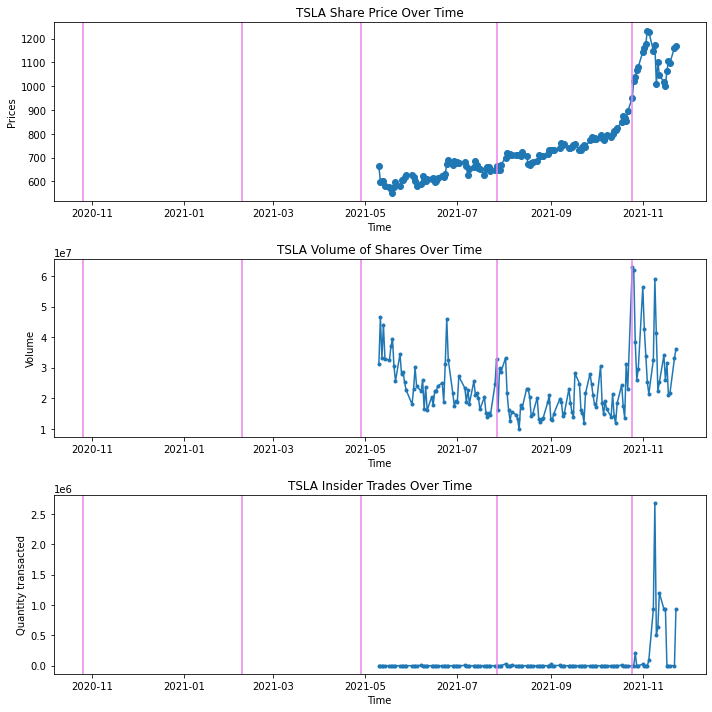

In [213]:
insider_trade_analysis('TSLA')

# Results

## The ARIMA model has higher performance, longer runtimes, and less convenient predictions for tomorrow
- Make 3 models, ARIMA, Daily, and hourly
- Compare time, performance, and usability

In [214]:
amzn_df = build_time_series_df('AMZN')
test_data, train_data = amzn_df[0:int(len(amzn_df)*.7)], \
                            amzn_df[int(len(amzn_df)*.7):]

train = train_data['Close'].values
test = test_data['Close'].values
# Create list of x train valuess
history = [x for x in train]
# establish list for predictions
model_predictions = []
# Count number of test data points
N_test_observations = len(test)
# loop through every data point
for time_point in range(N_test_observations):
    model = ARIMA(history, order=(5,1,1))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    model_predictions.append(yhat)
    true_test_value = test[time_point]
    history.append(true_test_value)
MAE_error = mean_absolute_error(test, model_predictions).numpy()
print('Testing Mean Absolute Error is {}'.format(MAE_error))

Testing Mean Absolute Error is 41.45525511774787


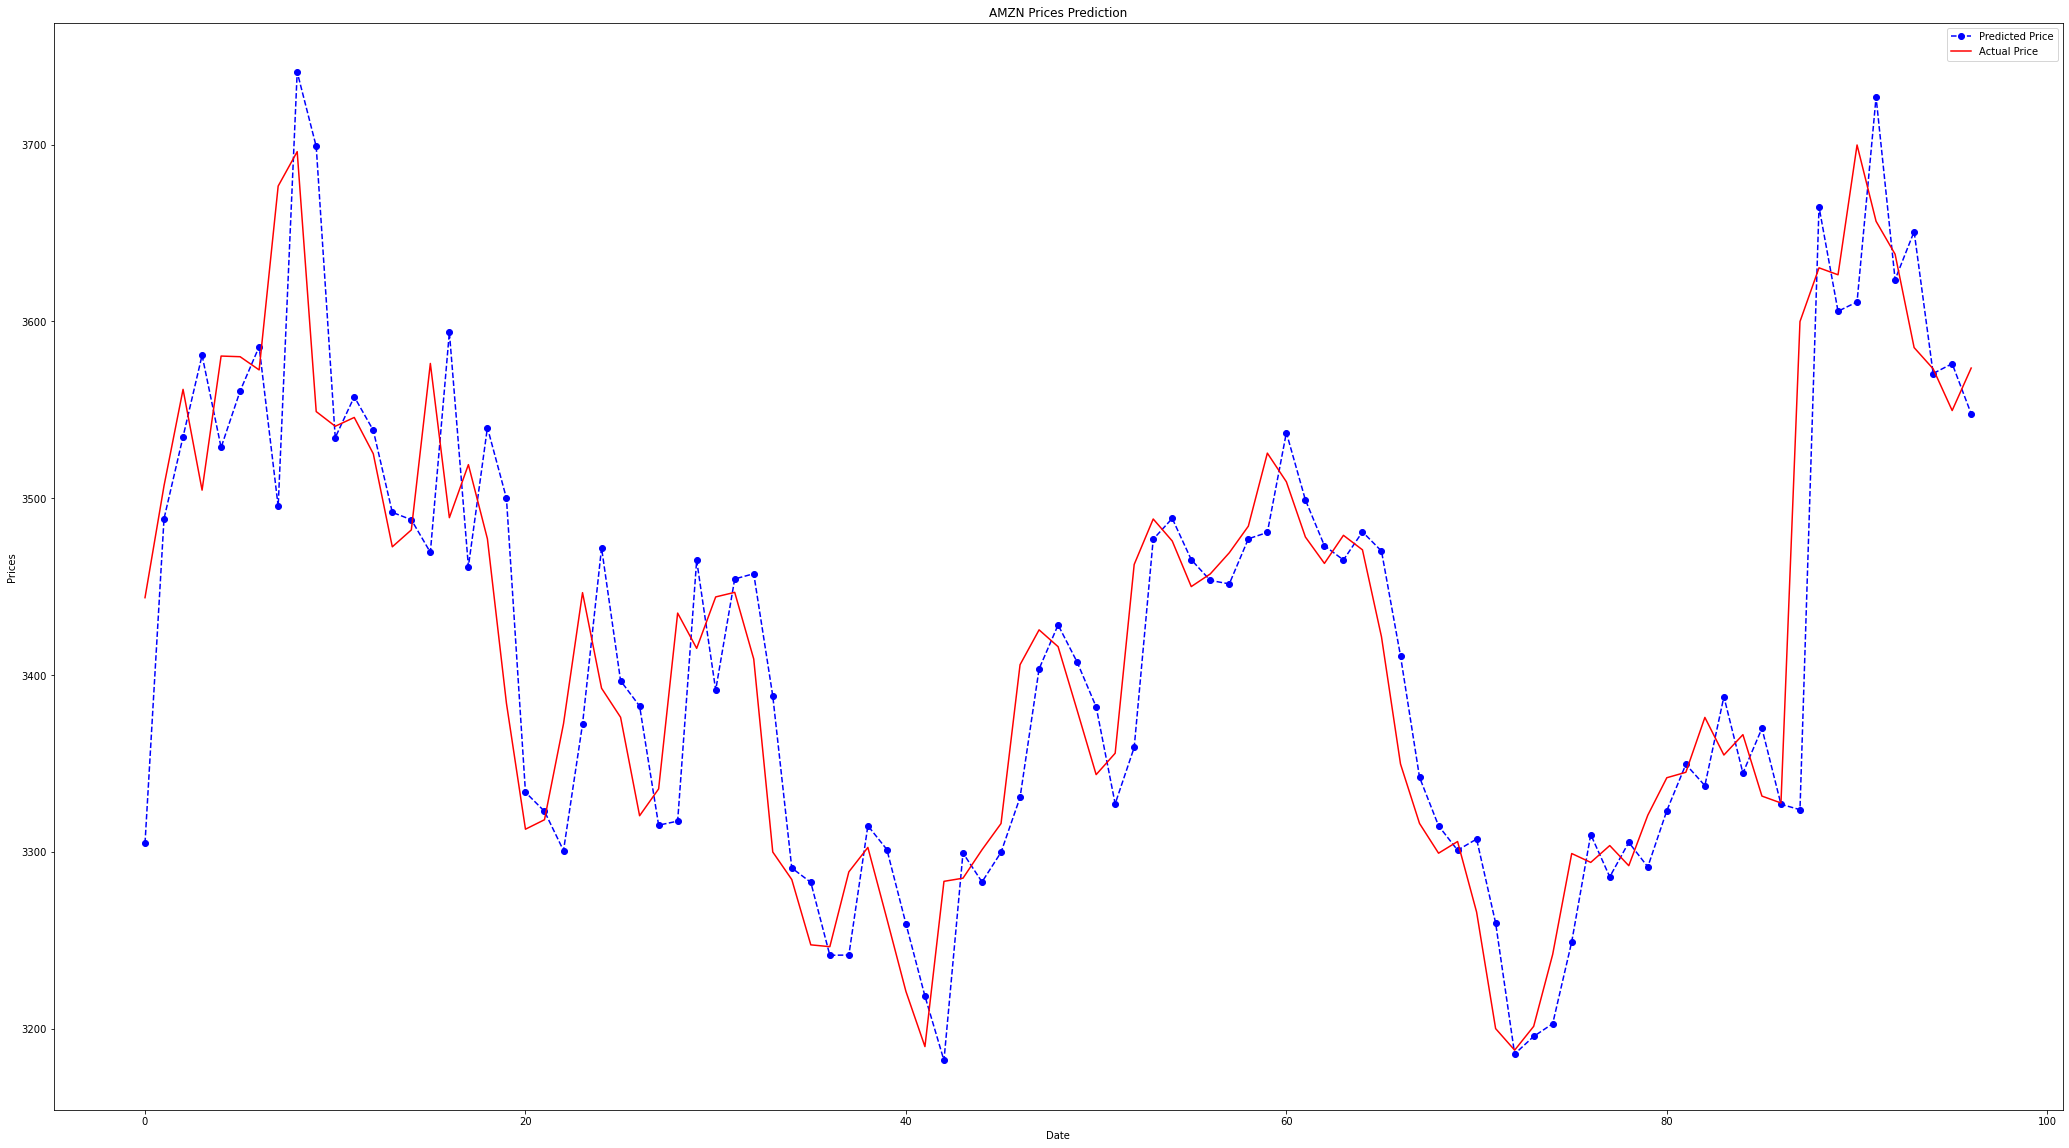

In [215]:
test_range = amzn_df[0:int(len(amzn_df)*.7)].index
plt.plot(test_range, model_predictions, color='blue', marker='o',
        linestyle ='dashed', label='Predicted Price')
plt.plot(test_range, test, color='red', label='Actual Price')
plt.title('AMZN Prices Prediction')
plt.xlabel('Date')
from pylab import rcParams
rcParams['figure.figsize'] = 36, 20
plt.ylabel('Prices')
plt.legend()
plt.show()

#### ARIMA has MAE of 45.5 for Amazon and took 14.6 seconds to run. There is not currently a method to predict tomorrow's close price with this model. I will now look at the daily model

In [216]:
xg_daily_df, xg_daily_model, prediction_daily_df, daily_mae = build_general_model_daily_prediction_df('AMZN')

In [217]:
fig = px.line(xg_daily_df, x='Date', y='value', color='data_category', markers=True,
              title = 'Daily Prediction For AMZN, Next Day Prediction: '+ \
              str(make_tomorrow_pred('AAPL', prediction_daily_df, xg_daily_model)) + '+/- '+str(daily_mae)
             )
fig.show()

#### Daily Stock model took 10.6 seconds and has an MAE of 73.4

In [218]:
xg_hourly_df, xg_hourly_model, prediction_hourly_df, hourly_mae = build_general_model_hourly_prediction_df('AMZN')

In [219]:
fig = px.line(xg_hourly_df, x='Time', y='value', color='data_category', markers=True,
              title = 'Hourly Prediction For AMZN, Next Hour Prediction: '+ \
              str(make_next_hour_pred('AMZN', prediction_hourly_df, xg_hourly_model)) + ' +/- '+str(hourly_mae)
             )
fig.show()

# Final Model Evaluation

- Above the final models are being tested on the holdout test sets and that can be seen through the visualizations. 
- These final models are very valuable to an investing analyst because they show visually and through an error rate (determined by the MAE of the model) how accurate of a prediction the model is making. This will increase confidence when making investments and can be used to detect when to sell investments.

#### Hourly modeling takes 1/2 of a second with an MAE of 44.5

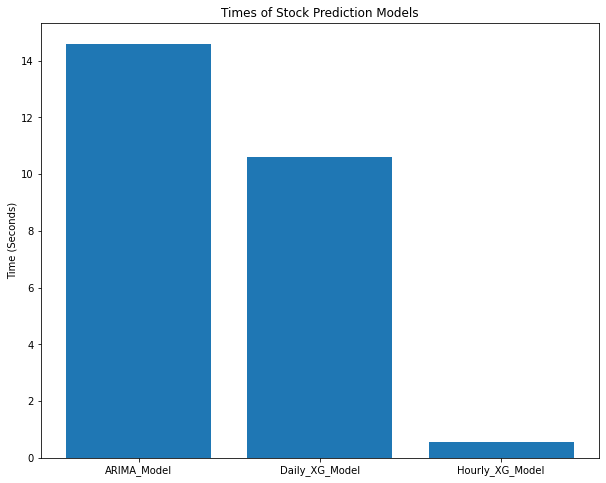

In [220]:

labels_time = ['ARIMA_Model', 'Daily_XG_Model', 'Hourly_XG_Model']
times = [14.6, 10.6, .573]



fig, ax = plt.subplots(figsize = (10,8))
ax.bar(x = labels_time, height = times )
ax.set_title('Times of Stock Prediction Models')
ax.set_ylabel('Time (Seconds)')
plt.show()

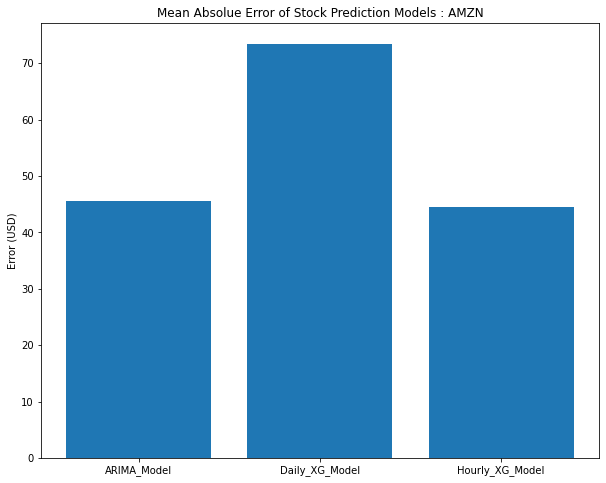

In [221]:
labels_mae = ['ARIMA_Model', 'Daily_XG_Model', 'Hourly_XG_Model']
times = [45.5, 73.45, 44.5]



fig, ax = plt.subplots(figsize = (10,8))
ax.bar(x = labels_time, height = times )
ax.set_title('Mean Absolue Error of Stock Prediction Models : AMZN')
ax.set_ylabel('Error (USD)')
plt.show()

## Adding news sentiment helps the xgboost model performance.

In [222]:
xg_daily_df, xg_daily_model, prediction_daily_df, daily_mae = build_general_model_daily_prediction_df('MSFT')

In [223]:
prediction_daily_df

,Close_1day,Close_2day,Close_3day,High_1day,High_2day,High_3day,Cot_1day,Cot_2day,Cot_3day,Vol_1day,Vol_2day,Vol_3day,value,Date,News_Sentiment_1day
0,330.590000,336.630000,329.680000,337.780000,339.030000,337.930000,-0.01411,0.00505,-0.01397,35737943.0,26461087.0,24218928.0,330.080000,2021-12-01,0.078250
1,336.630000,329.680000,337.910000,339.030000,337.930000,338.160000,0.00505,-0.01397,0.00485,26461087.0,24218928.0,21662699.0,330.590000,2021-11-30,0.121057
2,329.680000,337.910000,337.680000,337.930000,338.160000,339.450000,-0.01397,0.00485,0.00187,24218928.0,21662699.0,30381939.0,336.630000,2021-11-29,0.208775
3,337.910000,337.680000,339.830000,338.160000,339.450000,349.665000,0.00485,0.00187,-0.01390,21662699.0,30381939.0,31032206.0,329.680000,2021-11-26,0.223013
4,337.680000,339.830000,343.110000,339.450000,349.665000,345.100000,0.00187,-0.01390,0.00137,30381939.0,31032206.0,21963403.0,337.910000,2021-11-24,-0.278950
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129,249.309998,251.490005,251.720001,251.479996,252.940002,252.750000,-0.00741,0.00024,-0.00020,24426200.0,17771600.0,17704300.0,249.679993,2021-05-28,-0.285500
130,251.490005,251.720001,250.779999,252.940002,252.750000,251.160004,0.00024,-0.00020,0.01207,17771600.0,17704300.0,21411500.0,249.309998,2021-05-27,0.428517
131,251.720001,250.779999,245.169998,252.750000,251.160004,248.330002,-0.00020,0.01207,-0.00969,17704300.0,21411500.0,21863100.0,251.490005,2021-05-26,0.216464
132,250.779999,245.169998,246.479996,251.160004,248.330002,247.949997,0.01207,-0.00969,0.01033,21411500.0,21863100.0,21800700.0,251.720001,2021-05-25,0.073378


In [224]:
import seaborn as sns

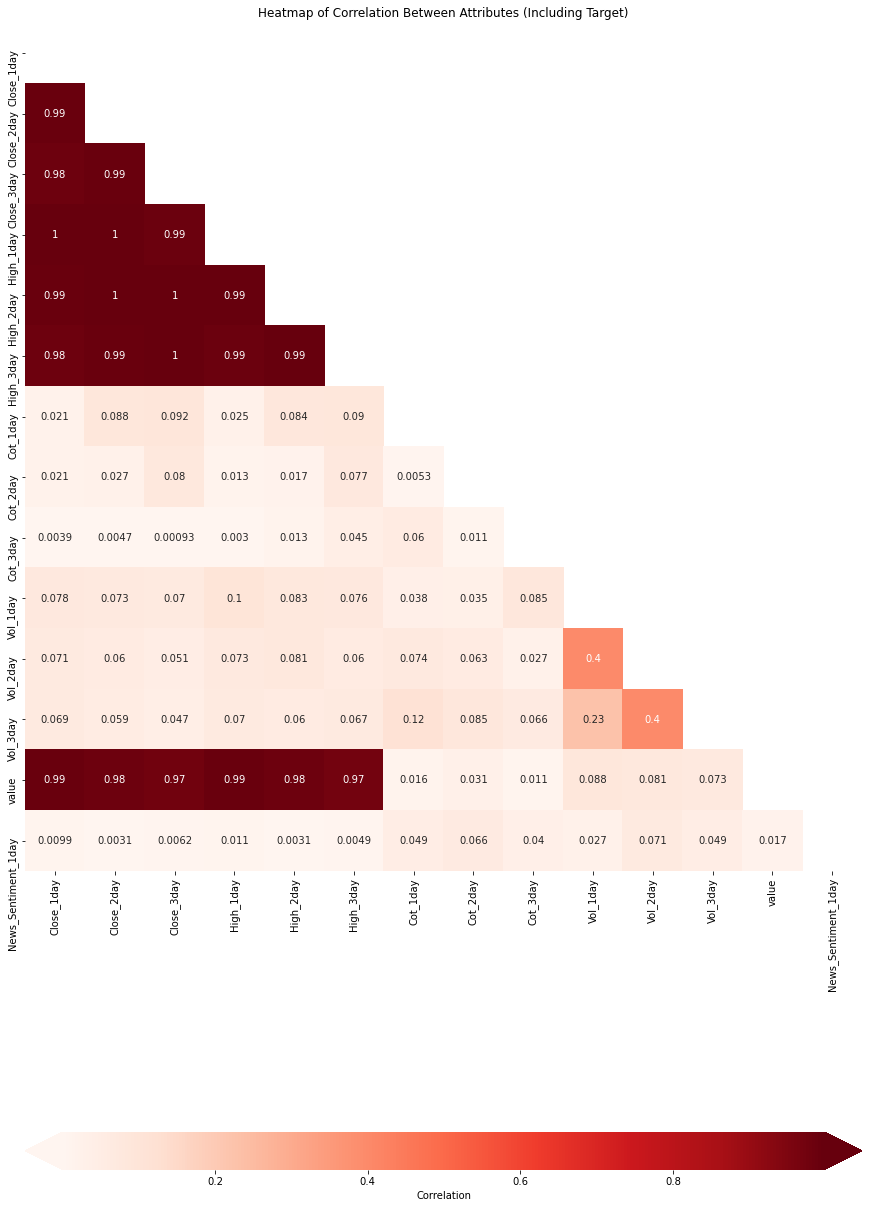

In [225]:

corr = prediction_daily_df.corr().abs()

# Set up figure and axes
fig, ax = plt.subplots(figsize=(15, 24))

# Plot a heatmap of the correlation matrix, with both
# numbers and colors indicating the correlations
sns.heatmap(
    cmap='Reds',
    # Specifies the data to be plotted
    data=corr,
    # The mask means we only show half the values,
    # instead of showing duplicates.
    mask=np.triu(np.ones_like(corr, dtype=bool)),
    # Specifies that we should use the existing axes
    ax=ax,
    # Specifies that we want labels, not just colors
    annot=True,
    # Customizes colorbar appearance
    cbar_kws={"label": "Correlation", "orientation": "horizontal", "pad": .2, "extend": "both"}
)

# Customize the plot appearance
ax.set_title("Heatmap of Correlation Between Attributes (Including Target)");

#### The news sentiment has a 10% Pearson correlation with the target close price.

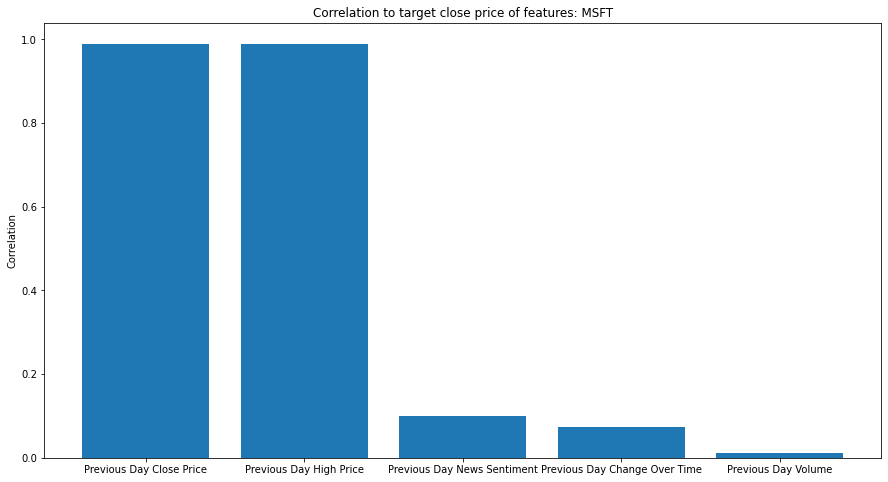

In [226]:
labels = ['Previous Day Close Price', 'Previous Day High Price', 'Previous Day News Sentiment',
         'Previous Day Change Over Time', 'Previous Day Volume']
corrs = [.99, .99 , .1, .074, .012]



fig, ax = plt.subplots(figsize = (15,8))
ax.bar(x = labels, height = corrs )
ax.set_title('Correlation to target close price of features: MSFT')
ax.set_ylabel('Correlation')
plt.show()

## When predicting stocks there is lots of noise introduced. Volatility is one of the biggest obstacles when predicting stock price.

#### To show this, I will show model performance of the hourly model with different intervals of test and train data.

#### 90/10 Split

In [227]:
xg_hourly_df, xg_hourly_model, prediction_hourly_df, hourly_mae = build_general_model_hourly_prediction_df('TSLA')

In [228]:
fig = px.line(xg_hourly_df, x='Time', y='value', color='data_category', markers=True,
              title = '90/10 SPLIT, Hourly Prediction For TSLA, Next Hour Prediction: '+ \
              str(make_next_hour_pred('TSLA', prediction_hourly_df, xg_hourly_model)) + ' +/- '+str(hourly_mae)
             )
fig.show()

#### 75/25 split

In [229]:
xg_hourly_df, xg_hourly_model, prediction_hourly_df, hourly_mae = build_general_model_hourly_prediction_df('TSLA')

In [230]:
fig = px.line(xg_hourly_df, x='Time', y='value', color='data_category', markers=True,
              title = '75/25 SPLIT, Hourly Prediction For TSLA, Next Hour Prediction: '+ \
              str(make_next_hour_pred('TSLA', prediction_hourly_df, xg_hourly_model)) + ' +/- '+str(hourly_mae)
             )
fig.show()

#### 60/40 Split

In [231]:
xg_hourly_df, xg_hourly_model, prediction_hourly_df, hourly_mae = build_general_model_hourly_prediction_df('TSLA')

In [232]:
fig = px.line(xg_hourly_df, x='Time', y='value', color='data_category', markers=True,
              title = '60/40 SPLIT, Hourly Prediction For TSLA, Next Hour Prediction: '+ \
              str(make_next_hour_pred('TSLA', prediction_hourly_df, xg_hourly_model)) + ' +/- '+str(hourly_mae)
             )
fig.show()

#### 95/5 Split

In [233]:
xg_hourly_df, xg_hourly_model, prediction_hourly_df, hourly_mae = build_general_model_hourly_prediction_df('TSLA')

In [234]:
fig = px.line(xg_hourly_df, x='Time', y='value', color='data_category', markers=True,
              title = '95/5 SPLIT, Hourly Prediction For TSLA, Next Hour Prediction: '+ \
              str(make_next_hour_pred('TSLA', prediction_hourly_df, xg_hourly_model)) + ' +/- '+str(hourly_mae)
             )
fig.show()

# Conclusions

- News sentiment provides valuable information to models.
- Arima models are too slow and ineffective for live dashboard predictions.
- Insider trades can be potential warning signs of a sell off event.

# Further Work

- Provide with more time, I would :
 - Investigate if/how insider training affects model performance
 - Implement analyst ratings to the prediction model
 - Investigate actively raising stocks to determine causers of such movement